# Generating Recidivism Data

The purpose of this notebook is to transform and clean data from North Carolina Department of Corrections into a dataset for predicting recidivsm of individual inmates. The scripts to download the raw, publically available data can be found in this repository. This notebook is likely best run on a server with suitable memory, as the data is fairly large. At the end, this exports a pickle of a pandas DF. For using in another script, the pickle is highly recommended, as import time and disk space is much lower. Can be changed to export a CSV for cross compatibility.

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

# Load In Data

### Court commitments data 
- At the individual commitment level (person and commitment IDs). We select a few columns based on what might be useful in predicting recidivism, what can be gotten elsewhere, and what doesn't contain too many NaN's.

In [3]:
court_commit = pd.read_csv('data/preprocessed/OFNT3BB1.csv')

/Users/lorenh/Documents/DSaPP/.triage/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (0,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
court_commit.tail(5)

,OFFENDER_NC_DOC_ID_NUMBER,COMMITMENT_PREFIX,COMMITTED_LAST_NAME,COMMITTED_FIRST_NAME,COMMITTED_MIDDLE_NAME,COMMITTED_NAME_SUFFIX,OFFENDER_ADMISSION/INTAKE_DATE,P&P_CASE_INTAKE_DATE,INMATE_COMMITMENT_STATUS_FLAG,COMMITMENT_STATUS_DATE,EARLIEST_SENTENCE_EFFECTIVE_DT,NEW_PERIOD_OF_INCARCERATION_FL,MOST_SERIOUS_OFFENSE_CODE,CO_OF_CONV_MOST_SERIOUS_OFFNSE,TOTAL_SENTENCE_LENGTH,TOTAL_JAIL_CREDITS_(IN_DAYS),NO_RESTITUTION_FLAG,P&P_COMMITMENT_STATUS_FLAG,P&P_COMMITMENT_STATUS_DATE,TOTAL_LENGTH_OF_SUPERVISION,PED_PRIOR_TO_1995_CONVERSION,DATE_OF_LAST_UPDATE,TIME_OF_LAST_UPDATE,NEW_PERIOD_OF_SUPERVISION_FLAG,TYPE_OF_OLD_PE_DATE_CODE
3525829,T683500,BA,JACKSON,CHRISTOPHER,NaN,NaN,2019-04-17,0001-01-01,ACTIVE,2019-04-04,2019-04-04,Y,STAT RAPE CHILD<=15DEF>6YRS,CUMBERLAND,91000.0,1058.0,NaN,NORMAL NORM,0001-01-01,0.0,0001-01-01,2019-04-18,08:21:38,N,NaN
3525830,T683509,BA,BYRD,RHONDA,LEA,NaN,2019-04-17,0001-01-01,ACTIVE,2019-04-02,2019-04-02,Y,EMBEZZLEMENT,FORSYTH,100000.0,0.0,NaN,NORMAL NORM,0001-01-01,0.0,0001-01-01,2019-04-18,11:52:35,N,NaN
3525831,T683918,BA,ALVARANGA,JAHMARI,RICKY,JR,2019-04-17,0001-01-01,ACTIVE,2019-03-18,2019-03-18,Y,ROBBERY W/DANGEROUS WEAPON,GUILFORD,41000.0,2.0,NaN,NORMAL NORM,0001-01-01,0.0,0001-01-01,2019-04-17,15:47:49,N,NaN
3525832,T684123,BA,SANDER,JONATHAN,NaN,NaN,2019-04-15,0001-01-01,ACTIVE,2019-04-15,2019-04-15,Y,MURDER FIRST DEGREE,WAKE,9999998.0,1116.0,NaN,NORMAL NORM,0001-01-01,0.0,0001-01-01,2019-04-16,11:37:55,N,NaN
3525833,T684187,BA,BAKER,AARON,DAWSON,NaN,2019-04-17,0001-01-01,ACTIVE,2019-04-15,2019-04-15,Y,ROBBERY W/DANGEROUS WEAPON,PITT,60200.0,309.0,NaN,NORMAL NORM,0001-01-01,0.0,0001-01-01,2019-04-17,16:10:48,N,NaN


In [5]:
court_commit_cols = ['OFFENDER_NC_DOC_ID_NUMBER', 'COMMITMENT_PREFIX', 'OFFENDER_ADMISSION/INTAKE_DATE', 
                     'NEW_PERIOD_OF_INCARCERATION_FL', 'P&P_COMMITMENT_STATUS_FLAG' , 'NEW_PERIOD_OF_SUPERVISION_FLAG']

In [6]:
court_commit['OFFENDER_ADMISSION/INTAKE_DATE'] = pd.to_datetime(court_commit['OFFENDER_ADMISSION/INTAKE_DATE'],
                                                               errors='coerce')

In [7]:
court_commit = court_commit[court_commit_cols]

#### Check whether any missing `OFFENDER_ADMISSION/INTAKE_DATE` values coded to Year 0001

In [11]:
court_commit['OFFENDER_ADMISSION/INTAKE_DATE'].min()

Timestamp('1921-09-30 00:00:00')

In [13]:
len(court_commit['OFFENDER_ADMISSION/INTAKE_DATE'].isna())

3525834

In [9]:
court_commit.to_pickle('data/preprocessed/court_commit.pkl')

In [5]:
court_commit = pd.read_pickle('data/preprocessed/court_commit.pkl')

### Inmates data
 - At the person level. All the data in the inmates table is aggregated over time, and therefore it has the risk of data leakage. Eg: Total_Sentence_Count could tell the algorithm that there will be upcoming sentences. Therefore, we want only the columns that could not change over time.

In [19]:
inmates = pd.read_csv('data/preprocessed/INMT4AA1.csv')

In [20]:
inmates.tail(5)

,INMATE_DOC_NUMBER,INMATE_LAST_NAME,INMATE_FIRST_NAME,INMATE_MIDDLE_INITIAL,INMATE_NAME_SUFFIX,INMATE_NAME_SOUNDEX_CODE,INMATE_GENDER_CODE,INMATE_RACE_CODE,INMATE_BIRTH_DATE,INMATE_ETHNIC_AFFILIATION,INMATE_RECORD_STATUS_CODE,INMATE_ADMIN._STATUS_CODE,CUSTODY_CLASS_CODE,NEXT_CUSTODY_REVIEW_DATE,INMATE_CONTROL_STATUS_CODE,NEXT_SECURITY_REVIEW_DATE,INMATE_SPECIAL_CHARACTERISTICS,PAROLE_CASE_ANALYST,NEXT_PAROLE_COMM._REVIEW_DATE,INMATE_PRIMARY_ASSIGNMENT,INMATE_ADMISSION_DATE,ADMITTING_DIAGNOSTIC_CENTER,DATE_OF_LAST_INMATE_MOVEMENT,TYPE_OF_LAST_INMATE_MOVEMENT,OTHER_FACILITY_CODE,CURRENT_DOP_COMMAND_CODE,CURRENT_DOP_AREA_CODE,INMATE_FACILITY_CODE,INMATE_TIME_COMP_STATUS_CODE,OLDEST_COMMIT.OF_CURRENT_INCAR,OLDEST_SNT.CMP._OF_CURR.INCAR.,OLDEST_CONVICTION_DATE,TOTAL_SENTENCE_COUNT,MOST_SERIOUS_OFFNSE_CURR_INCAR,INMATE_IS_FELON/MISDEMEANANT,CURRENT_COMMITMENT_PREFIX,CURRENT_SENTENCE_COMPONENT,TOTAL_SENTENCE_LENGTH(IN_DAYS),LENGTH_OF_CURRENT_INCARCERATN.,TERM_OF_INCARCERATION(IN_DAYS),LENGTH_OF_RULING_SENTENCES,LAST_RULING_PRD_COMMITMENT,LAST_RULING_PRD_COMPONENT,FINAL_RULING_PED,FINAL_RULING_TRD,FINAL_RULING_PRD,FINAL_RULING_MAX_RELEASE_DATE,LAW_FOR_FINAL_RULING_DATES,DAYS_SERVED_IN_DOC_CUSTODY,DATE_TRD_&_PRD_LAST_COMPUTED,ON/OFF_GAIN_TIME_CODE,GT_RATE_/_ET_LEVEL_CODE,LAST_DATE_ON/OFF_GAIN_TIME,TOTAL_DISCIPLINE_INFRACTIONS,LATEST_DISCIPLINE_INFRACTION,LAST_DISCIPLINE_INFRACTION_DT.,DATE_OF_LAST_ARREST_ON_PAROLE,CURRENT_PENDING_REVIEWS_FLAG,ESCAPE_HISTORY_FLAG,PRIOR_INCARCERATIONS_FLAG,NEXT_PAROLE_REVIEW_TYPE_CODE,TIME_OF_LAST_MOVEMENT,POPULATION/MANAGEMENT_UNIT,INMATE_POSITIVELY_IDENTIFIED,PAROLE_AND_TERMINATE_STATUS,INMATE_LABEL_STATUS_CODE,PRIMARY_OFFENSE_QUALIFIER
461266,T684058,HANSEN,JESSE,D,NaN,NaN,MALE,WHITE,1996-10-03,NaN,ACTIVE,ACTIVE,MEDIUM MED,0001-01-01,REGULAR POPULATION RPOP,0001-01-01,REGULAR,NaN,0001-01-01,NaN,2019-04-18,POLK YI DIAG CTR NEW,2019-04-18,NEW ADMISSION,NEW HANOVER COUNTY,2075,3980,POLK CI POLK,NEITHER PRD NOR PED COMPUTED,NaN,NaN,0001-01-01,0,NaN,FELON,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0001-01-01,0001-01-01,0001-01-01,0001-01-01,NaN,0,2019-04-18,NaN,NaN,0001-01-01,0,NaN,0001-01-01,0001-01-01,N,N,NaN,NaN,15:20:00,NaN,NO,NaN,NaN,NaN
461267,T684123,SANDER,JONATHAN,NaN,NaN,NaN,MALE,WHITE,1963-07-24,NaN,ACTIVE,ACTIVE,CLOSE CLS,0001-01-01,REGULAR POPULATION RPOP,0001-01-01,REGULAR,BRM11,0001-01-01,NaN,2019-04-15,CENTRAL PRISON D. C.,2019-04-15,NEW ADMISSION,WAKE COUNTY,2075,3100,CENTRAL PRISON CENT,NEITHER PRD NOR PED COMPUTED,BA,1.0,0001-01-01,0,NaN,FELON,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0001-01-01,0001-01-01,0001-01-01,0001-01-01,NaN,0,2019-04-17,NaN,NaN,0001-01-01,0,NaN,0001-01-01,0001-01-01,N,N,NaN,NaN,19:24:00,NaN,NO,NaN,NaN,NaN
461268,T684187,BAKER,AARON,D,NaN,NaN,MALE,BLACK,2001-05-28,AFRICAN,ACTIVE,ACTIVE,MEDIUM MED,0001-01-01,REGULAR POPULATION RPOP,0001-01-01,REGULAR,CKL02,0001-01-01,NaN,2019-04-17,NaN,2019-04-17,NEW ADMISSION,PITT COUNTY,2071,3720,FOOTHILLS CI FOOT,NEITHER PRD NOR PED COMPUTED,BA,1.0,0001-01-01,0,NaN,FELON,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0001-01-01,0001-01-01,0001-01-01,0001-01-01,NaN,0,2019-04-17,NaN,NaN,0001-01-01,0,NaN,0001-01-01,0001-01-01,N,N,NaN,NaN,15:09:00,NaN,NO,NaN,NaN,NaN
461269,T684216,LOFTIN,NATHAN,J,II,NaN,MALE,BLACK,1988-11-27,NaN,ACTIVE,ACTIVE,MEDIUM MED,0001-01-01,REGULAR POPULATION RPOP,0001-01-01,REGULAR,NaN,0001-01-01,NaN,2019-04-18,CENTRAL PRISON D. C.,2019-04-18,NEW ADMISSION,WAYNE COUNTY,2075,3100,CENTRAL PRISON CENT,NEITHER PRD NOR PED COMPUTED,NaN,NaN,0001-01-01,0,NaN,FELON,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0001-01-01,0001-01-01,0001-01-01,0001-01-01,NaN,0,2019-04-18,NaN,NaN,0001-01-01,0,NaN,0001-01-01,0001-01-01,N,N,NaN,NaN,15:27:00,NaN,NO,NaN,NaN,NaN
461270,T684365,RODRIGUEZ,RUBEN,G,NaN,NaN,MALE,OTHER,1988-02-09,NaN,ACTIVE,ACTIVE,MINIMUM 1 MN1,0001-01-01,REGULAR POPULATION RPOP,0001-01-01,REGULAR,NaN,0001-01-01,NaN,2019-04-18,PIEDMONT CI DIAG CTR,2019-04-18,NEW ADMISSION,ALLEGHANY COUNTY,2071,3500,PIEDMONT CI PIED,NEITHER PRD NOR PED COMPUTED,NaN,NaN,0001-01-0

In [21]:
inmates_cols = ['INMATE_DOC_NUMBER', 'INMATE_GENDER_CODE', 'INMATE_RACE_CODE', 'INMATE_BIRTH_DATE']

In [22]:
def convert_dates(date_series, date_format='%Y-%m-%d', timestamp=False):
    '''
    Faster approach to datetime parsing for large datasets leveraging repated dates.

    Attribution: https://github.com/sanand0/benchmarks/commit/0baf65b290b10016e6c5118f6c4055b0c45be2b0
    '''
    if timestamp:
        dates = {date:pd.to_datetime(date, errors='coerce') for date in date_series.unique()}
    else:
        dates = {date: datetime.strptime(date, date_format) for date in date_series.unique()}
    return date_series.map(dates)


In [23]:
inmates['INMATE_BIRTH_DATE'].tail()

461266    1996-10-03
461267    1963-07-24
461268    2001-05-28
461269    1988-11-27
461270    1988-02-09
Name: INMATE_BIRTH_DATE, dtype: object

In [24]:
inmates['INMATE_BIRTH_DATE'] =  convert_dates(inmates['INMATE_BIRTH_DATE'], timestamp=True)

In [18]:
# Dropping 218 inmates without a birthdate recorded.
# inmates = inmates[inmates['INMATE_BIRTH_DATE'].notnull()]

In [25]:
inmates = inmates[inmates_cols]

In [26]:
inmates.loc[inmates['INMATE_DOC_NUMBER'] == 54932]

,INMATE_DOC_NUMBER,INMATE_GENDER_CODE,INMATE_RACE_CODE,INMATE_BIRTH_DATE
28867,54932,MALE,WHITE,1999-09-28


#### Check if missing birthdates coded to Year 0001 or outside pandas date range (Year 2622)

In [28]:
inmates['INMATE_BIRTH_DATE'].min()

Timestamp('1899-08-28 00:00:00')

In [30]:
inmates['INMATE_BIRTH_DATE'].max()

Timestamp('2004-07-12 00:00:00')

In [31]:
len(inmates['INMATE_BIRTH_DATE'].isna())

461271

In [34]:
inmates.to_pickle('data/preprocessed/inmates.pkl')

In [7]:
inmates = pd.read_pickle('data/preprocessed/inmates.pkl')

### Sentence computation data 
- At the individual commitment level (person and commitment IDs), containing pertinent dates for the sentences. Sentences served consecutively for a given inmate will have the same COMMITMENT_PREFIX and subsequent SENTENCE_COMPONENTs (it seems). For our purposes, we need the initial beginning date of each sentence and the final end date.

In [35]:
sentence_computation = pd.read_csv('data/preprocessed/INMT4BB1.csv')

In [36]:
sentence_computation.tail(5)

,INMATE_DOC_NUMBER,INMATE_COMMITMENT_PREFIX,INMATE_SENTENCE_COMPONENT,INMATE_COMPUTATION_STATUS_FLAG,SENTENCE_BEGIN_DATE_(FOR_MAX),ACTUAL_SENTENCE_END_DATE,PROJECTED_RELEASE_DATE_(PRD),PAROLE_DISCHARGE_DATE,PAROLE_SUPERVISION_BEGIN_DATE
1704946,1609500,BA,1,ACTIVE,2019-04-11,2019-04-17,2019-04-17,0001-01-01,0001-01-01
1704947,1609905,BA,1,ACTIVE,2019-04-17,2019-04-24,2019-04-24,0001-01-01,0001-01-01
1704948,1610013,BA,1,ACTIVE,2019-04-08,2019-04-25,2019-04-25,0001-01-01,0001-01-01
1704949,1610047,BA,1,ACTIVE,2019-04-02,2019-04-25,2019-04-25,0001-01-01,0001-01-01
1704950,1610101,BA,1,ACTIVE,2019-04-11,2019-04-25,2019-04-25,0001-01-01,0001-01-01


### Sentence data 
- At the individual commitment level. Contains data on the sentence. This will be the primary basis for our columns. 

In [434]:
sentences = pd.read_csv('data/preprocessed/OFNT3CE1.csv')

/Users/lorenh/Documents/DSaPP/.triage/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (0,21,25,33,41,53) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [38]:
sentences.loc[sentences['SENTENCE_COMPONENT_NUMBER'] > 1]

,OFFENDER_NC_DOC_ID_NUMBER,COMMITMENT_PREFIX,SENTENCE_COMPONENT_NUMBER,COUNTY_OF_CONVICTION_CODE,COURT_DOCKET_NUMBER,PUNISHMENT_TYPE_CODE,COURT_TYPE_CODE,COMPONENT_DISPOSITION_CODE,CMP._DISPOSITION_CODE_(2_OF_2),NUMBER_OF_COUNTS,TYPE_OF_COUNT_CODE,PRIMARY_OFFENSE_CODE,OFFENSE_QUALIFIER_CODE,DATE_OFFENSE_COMMITTED_-_BEGIN,DATE_OFFENSE_COMMITTED_-_END,NC_GENERAL_STATUTE_NUMBER,PRIMARY_FELONY/MISDEMEANOR_CD.,SENTENCING_PENALTY_CLASS_CODE,PRIOR_RCD._POINTS/CONVICTIONS,PRIOR_RECORD_LEVEL_CODE,MINIMUM_SENTENCE_LENGTH,MAXIMUM_SENTENCE_LENGTH,LENGTH_OF_SUPERVISION,SUPERVISION_TERM_EXTENSION,SUPERVISION_TO_FOLLOW_INCAR.,SPLIT_SENTENCE_ACTIVE_TERM,G.S._MAXIMUM_SENTENCE_ALLOWED,SERVING_MIN_OR_MAX_TERM_CODE,SENTENCE_TYPE_CODE,SENTENCE_TYPE_CODE.1,SENTENCE_TYPE_CODE.2,SENTENCE_TYPE_CODE.3,SENTENCE_TYPE_CODE.4,SENTENCE_TYPE_CODE.5,CREDITS_FOR_JAIL_DAYS_SERVED,ICC_JAIL_CREDITS_(IN_DAYS),SENTENCE_CHAINING_TYPE_CODE,PRIOR_COMMITMENT_PREFIX,PRIOR_COMPONENT_IDENTIFIER,P&P_SUPV.TERM_CHAIN_TYPE_CODE,P&P_PRIOR_COMMITMENT_PREFIX,PRIOR_P&P_COMMNT/COMPONENT_ID,TIME_COMPUTATION_EXCEPTION_CD.,SENTENCE_CONVICTION_DATE,SENTENCE_EFFECTIVE(BEGIN)_DATE,DELEGATED_AUTHORITY_FLAG,INMATE_SENTENCE_STATUS_CODE,INMATE_COMPONENT_STATUS_DATE,P&P_CASE_STATUS,P&P_COMPONENT_STATUS_DATE,DATE_OF_LAST_UPDATE,TIME_OF_LAST_UPDATE,ORIGINAL_DATA_ENTRY_DATE,ORIGINAL_SENTENCE_AUDIT_CODE,DATE_OF_LAST_UPDATE_TWO,TIME_OF_LAST_UPDATE_TWO
4,4,AA,2,PERQUIMANS,83000802.0,FAIR FELONS,SUPERIOR,UNKNOWN,NaN,1,NaN,SELL SCHEDULE II,AID&ABET,0001-01-01,0001-01-01,NaN,FELON,CLASS H,0,NaN,0,30000,0.0,0.0,225.0,0000000,0.0,MAX.TERM:,DEPT OF CORR DIV OF PRISONS,NaN,NaN,NaN,NaN,NaN,8,0,CONCURRENT,AA,1.0,NaN,NaN,NaN,NOT APPLICABLE,1983-07-12,1983-07-12,NaN,ACTIVE,1983-07-13,NaN,0001-01-01,0001-01-01,01:00:00,0001-01-01,CONVERSION CC,0001-01-01,01:00:00
9,6,AB,2,CUMBERLAND,NaN,PRE-FAIR,DISTRICT,UNKNOWN,NaN,1,NaN,WORTHLESS CHECK,PRINCIPAL,0001-01-01,0001-01-01,NaN,MISD.,MISD.(PRE-STRUCTURE),0,NaN,30,0,0.0,0.0,628.0,0000000,NaN,MIN.TERM:,DEPT OF CORR DIV OF PRISONS,NaN,NaN,NaN,NaN,NaN,0,0,CONSECUTIV,AB,1.0,NaN,NaN,NaN,NOT APPLICABLE,1973-04-11,1973-04-11,NaN,ACTIVE,1973-04-15,NaN,0001-01-01,0001-01-01,01:00:00,0001-01-01,CONVERSION CS,0001-01-01,01:00:00
10,6,AB,3,CUMBERLAND,NaN,PRE-FAIR,DISTRICT,UNKNOWN,NaN,1,NaN,WORTHLESS CHECK,PRINCIPAL,0001-01-01,0001-01-01,NaN,MISD.,MISD.(PRE-STRUCTURE),0,NaN,30,0,0.0,0.0,628.0,0000000,NaN,MIN.TERM:,DEPT OF CORR DIV OF PRISONS,NaN,NaN,NaN,NaN,NaN,0,0,CONSECUTIV,AB,2.0,NaN,NaN,NaN,NOT APPLICABLE,1973-04-11,1973-04-11,NaN,ACTIVE,1973-04-15,NaN,0001-01-01,0001-01-01,01:00:00,0001-01-01,CONVERSION CS,0001-01-01,01:00:00
11,6,AB,4,CUMBERLAND,NaN,PRE-FAIR,DISTRICT,UNKNOWN,NaN,1,NaN,WORTHLESS CHECK,PRINCIPAL,0001-01-01,0001-01-01,NaN,MISD.,MISD.(PRE-STRUCTURE),0,NaN,30,0,0.0,0.0,628.0,0000000,NaN,MIN.TERM:,DEPT OF CORR DIV OF PRISONS,NaN,NaN,NaN,NaN,NaN,0,0,CONSECUTIV,AB,3.0,NaN,NaN,NaN,NOT APPLICABLE,1973-04-11,1973-04-11,NaN,ACTIVE,1973-04-15,NaN,0001-01-01,0001-01-01,01:00:00,0001-01-01,CONVERSION CS,0001-01-01,01:00:00
12,6,AB,5,CUMBERLAND,NaN,PRE-FAIR,DISTRICT,UNKNOWN,NaN,1,NaN,WORTHLESS CHECK,PRINCIPAL,0001-01-01,0001-01-01,NaN,MISD.,MISD.(PRE-STRUCTURE),0,NaN,30,0,0.0,0.0,628.0,0000000,NaN,MIN.TERM:,DEPT OF CORR DIV OF PRISONS,NaN,NaN,NaN,NaN,NaN,0,0,CONSECUTIV,AB,4.0,NaN,NaN,NaN,NOT APPLICABLE,1973-04-11,1973-04-11,NaN,ACTIVE,1973-04-15,NaN,0001-01-01,0001-01-01,01:00:00,0001-01-01,CONVERSION CS,0001-01-01,01:00:00
13,6,AB,6,CUMBERLAND,NaN,PRE-FAIR,DISTRICT,UNKNOWN,NaN,1,NaN,WORTHLESS CHECK,PRINCIPAL,0001-01-01,0001-01-01,NaN,MISD.,MISD.(PRE-STRUCTURE),0,NaN,30,0,0.0,0.0,628.0,0000000,NaN,MIN.TERM:,DEPT OF CORR DIV OF PRISONS,NaN,NaN,NaN,NaN,NaN,0,0,CONSECUTIV,AB,5.0,NaN,NaN,NaN,NOT APPLICABLE,1973-04-11,1973-04-11,NaN,ACTIVE,1973-04-15,NaN,0001-01-01,0001-01-01,01:00:00,0001-01-01,CONVERSION CS,0001-01-01,01:00:00
14,6,AB,7,CUMBERLAND,NaN,PRE-FAIR,DISTRICT,UNKNOWN,NaN,1,NaN,WORTHLESS CHECK,PRINCIPAL,0001-01-01,0001-01-01,NaN,MISD.,MISD.(PRE-STRUCTURE),0,NaN,30,

In [126]:
sentences.tail(5)

,OFFENDER_NC_DOC_ID_NUMBER,COMMITMENT_PREFIX,SENTENCE_COMPONENT_NUMBER,COUNTY_OF_CONVICTION_CODE,COURT_DOCKET_NUMBER,PUNISHMENT_TYPE_CODE,COURT_TYPE_CODE,COMPONENT_DISPOSITION_CODE,CMP._DISPOSITION_CODE_(2_OF_2),NUMBER_OF_COUNTS,TYPE_OF_COUNT_CODE,PRIMARY_OFFENSE_CODE,OFFENSE_QUALIFIER_CODE,DATE_OFFENSE_COMMITTED_-_BEGIN,DATE_OFFENSE_COMMITTED_-_END,NC_GENERAL_STATUTE_NUMBER,PRIMARY_FELONY/MISDEMEANOR_CD.,SENTENCING_PENALTY_CLASS_CODE,PRIOR_RCD._POINTS/CONVICTIONS,PRIOR_RECORD_LEVEL_CODE,MINIMUM_SENTENCE_LENGTH,MAXIMUM_SENTENCE_LENGTH,LENGTH_OF_SUPERVISION,SUPERVISION_TERM_EXTENSION,SUPERVISION_TO_FOLLOW_INCAR.,SPLIT_SENTENCE_ACTIVE_TERM,G.S._MAXIMUM_SENTENCE_ALLOWED,SERVING_MIN_OR_MAX_TERM_CODE,SENTENCE_TYPE_CODE,SENTENCE_TYPE_CODE.1,SENTENCE_TYPE_CODE.2,SENTENCE_TYPE_CODE.3,SENTENCE_TYPE_CODE.4,SENTENCE_TYPE_CODE.5,CREDITS_FOR_JAIL_DAYS_SERVED,ICC_JAIL_CREDITS_(IN_DAYS),SENTENCE_CHAINING_TYPE_CODE,PRIOR_COMMITMENT_PREFIX,PRIOR_COMPONENT_IDENTIFIER,P&P_SUPV.TERM_CHAIN_TYPE_CODE,P&P_PRIOR_COMMITMENT_PREFIX,PRIOR_P&P_COMMNT/COMPONENT_ID,TIME_COMPUTATION_EXCEPTION_CD.,SENTENCE_CONVICTION_DATE,SENTENCE_EFFECTIVE(BEGIN)_DATE,DELEGATED_AUTHORITY_FLAG,INMATE_SENTENCE_STATUS_CODE,INMATE_COMPONENT_STATUS_DATE,P&P_CASE_STATUS,P&P_COMPONENT_STATUS_DATE,DATE_OF_LAST_UPDATE,TIME_OF_LAST_UPDATE,ORIGINAL_DATA_ENTRY_DATE,ORIGINAL_SENTENCE_AUDIT_CODE,DATE_OF_LAST_UPDATE_TWO,TIME_OF_LAST_UPDATE_TWO
4257487,1610101,BA,1,HENDERSON,17050540.0,ACTIVE SS,SUPERIOR,NEGOTIATED PLEA,NaN,1,CONCURRENT,AWDWISI,PRINCIPAL,2017-02-10,2017-02-10,14-33(B),FELON,CLASS E,0,LEVEL I,10800,30000,0.0,0.0,0.0,0,0.0,MAX.TERM:,DEPT OF CORR DIV OF PRISONS,JAIL POST RELEASE,NaN,NaN,NaN,NaN,791,0,INITIAL,NaN,NaN,NaN,NaN,NaN,FLAT TIME JAIL CRDT.,2019-04-11,2019-04-11,NaN,ACTIVE,2019-04-11,NORMAL NORM,2019-04-11,2019-04-18,13:47:15,2019-04-18,NaN,2019-04-18,13:46:08
4257488,1610104,01,1,PITT,18052768.0,DWI,DISTRICT,GUILTY,NaN,1,CONCURRENT,DWI LEVEL 5,PRINCIPAL,2018-04-16,2018-04-16,NaN,MISD.,NON CLASS CODE,0,NaN,0,0,1200.0,0.0,0.0,0,NaN,MAX.TERM:,PROBATION,SUSPENDED SENTENCE,DWI CONVICTION,NaN,NaN,NaN,0,0,NaN,NaN,NaN,INITIAL,NaN,NaN,NOT APPLICABLE,2019-04-18,2019-04-18,N,NaN,0001-01-01,NORMAL NORM,2019-04-18,2019-04-18,15:12:20,2019-04-18,NaN,2019-04-18,15:12:20
4257489,1610118,01,1,WAKE,18002289.0,COMMUNITY SS (DCC),DISTRICT,BENCH TRIAL,BENCH TRIAL,1,CONCURRENT,RECKLESS DRIVING,PRINCIPAL,2018-07-21,2018-07-21,20-140(B),MISD.,CLASS 2 MISDEMEANOR SS,2,LEVEL II,0,0,1200.0,0.0,0.0,0,NaN,MAX.TERM:,PROBATION,SUSPENDED SENTENCE,COUNTY JAIL,NaN,NaN,NaN,0,0,NaN,NaN,NaN,INITIAL,NaN,NaN,NOT APPLICABLE,2019-04-18,2019-04-18,Y,NaN,0001-01-01,NORMAL NORM,2019-04-18,2019-04-18,16:01:56,2019-04-18,NaN,2019-04-18,16:01:56
4257490,1610128,01,1,SAMPSON,17052701.0,DWI,DISTRICT,GUILTY,GUILTY,1,CONCURRENT,DWI LEVEL 5,PRINCIPAL,2017-10-01,2017-10-01,20-138.1,MISD.,NON CLASS CODE,0,NaN,0,0,1200.0,0.0,0.0,0,NaN,MAX.TERM:,PROBATION,SUSPENDED SENTENCE,DWI CONVICTION,NaN,NaN,NaN,0,0,NaN,NaN,NaN,INITIAL,NaN,NaN,NOT APPLICABLE,2019-04-18,2019-04-18,N,NaN,0001-01-01,NORMAL NORM,2019-04-18,2019-04-18,17:26:48,2019-04-18,NaN,2019-04-18,17:26:48
4257491,T153879,01,1,DARE,99003876.0,COMMUNITY SS (DCC),SUPERIOR,GUILTY,GUILTY,1,CONCURRENT,CONSPIRACY,PRINCIPAL,1999-07-02,1999-07-02,90 95,FELON,CLASS H,0,LEVEL I,600,800,NaN,NaN,NaN,0,NaN,MAX.TERM:,PROBATION,SUSPENDED SENTENCE,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,INITIAL,NaN,NaN,NOT APPLICABLE,1999-09-27,1999-09-27,N,NaN,0001-01-01,TOLLED TOLLD,2000-09-26,2000-10-20,11:20:45,1999-10-07,NaN,2000-09-26,09:07:51


#### Pull out two entities with a lot of variation/ rows in raw data to determine what columns can be collapsed in sentences table and what will need to be grouped at offense level in events table.

In [39]:
pd.DataFrame(sentences.loc[sentences['OFFENDER_NC_DOC_ID_NUMBER'] == 19])

,OFFENDER_NC_DOC_ID_NUMBER,COMMITMENT_PREFIX,SENTENCE_COMPONENT_NUMBER,COUNTY_OF_CONVICTION_CODE,COURT_DOCKET_NUMBER,PUNISHMENT_TYPE_CODE,COURT_TYPE_CODE,COMPONENT_DISPOSITION_CODE,CMP._DISPOSITION_CODE_(2_OF_2),NUMBER_OF_COUNTS,TYPE_OF_COUNT_CODE,PRIMARY_OFFENSE_CODE,OFFENSE_QUALIFIER_CODE,DATE_OFFENSE_COMMITTED_-_BEGIN,DATE_OFFENSE_COMMITTED_-_END,NC_GENERAL_STATUTE_NUMBER,PRIMARY_FELONY/MISDEMEANOR_CD.,SENTENCING_PENALTY_CLASS_CODE,PRIOR_RCD._POINTS/CONVICTIONS,PRIOR_RECORD_LEVEL_CODE,MINIMUM_SENTENCE_LENGTH,MAXIMUM_SENTENCE_LENGTH,LENGTH_OF_SUPERVISION,SUPERVISION_TERM_EXTENSION,SUPERVISION_TO_FOLLOW_INCAR.,SPLIT_SENTENCE_ACTIVE_TERM,G.S._MAXIMUM_SENTENCE_ALLOWED,SERVING_MIN_OR_MAX_TERM_CODE,SENTENCE_TYPE_CODE,SENTENCE_TYPE_CODE.1,SENTENCE_TYPE_CODE.2,SENTENCE_TYPE_CODE.3,SENTENCE_TYPE_CODE.4,SENTENCE_TYPE_CODE.5,CREDITS_FOR_JAIL_DAYS_SERVED,ICC_JAIL_CREDITS_(IN_DAYS),SENTENCE_CHAINING_TYPE_CODE,PRIOR_COMMITMENT_PREFIX,PRIOR_COMPONENT_IDENTIFIER,P&P_SUPV.TERM_CHAIN_TYPE_CODE,P&P_PRIOR_COMMITMENT_PREFIX,PRIOR_P&P_COMMNT/COMPONENT_ID,TIME_COMPUTATION_EXCEPTION_CD.,SENTENCE_CONVICTION_DATE,SENTENCE_EFFECTIVE(BEGIN)_DATE,DELEGATED_AUTHORITY_FLAG,INMATE_SENTENCE_STATUS_CODE,INMATE_COMPONENT_STATUS_DATE,P&P_CASE_STATUS,P&P_COMPONENT_STATUS_DATE,DATE_OF_LAST_UPDATE,TIME_OF_LAST_UPDATE,ORIGINAL_DATA_ENTRY_DATE,ORIGINAL_SENTENCE_AUDIT_CODE,DATE_OF_LAST_UPDATE_TWO,TIME_OF_LAST_UPDATE_TWO
65,19,AA,1,IREDELL,88004316.0,FAIR MISDEMEAN,DISTRICT,UNKNOWN,NaN,1,NaN,MISD B&E,PRINCIPAL,0001-01-01,0001-01-01,NaN,MISD.,MISD.(PRE-STRUCTURE),0,NaN,2400,2400,NaN,NaN,NaN,0000000,0.0,MAX.TERM:,DEPT OF CORR DIV OF PRISONS,NaN,NaN,NaN,NaN,NaN,96,0,INITIAL,NaN,NaN,NaN,NaN,NaN,NOT APPLICABLE,1988-05-05,1988-07-14,NaN,ACTIVE,1988-07-15,NaN,0001-01-01,0001-01-01,01:00:00,0001-01-01,CONVERSION CS,0001-01-01,01:00:00
66,19,AA,2,IREDELL,88004316.0,FAIR MISDEMEAN,DISTRICT,UNKNOWN,NaN,1,NaN,LARCENY (OVER $200),PRINCIPAL,0001-01-01,0001-01-01,NaN,MISD.,MISD.(PRE-STRUCTURE),0,NaN,2400,2400,NaN,NaN,NaN,0000000,0.0,MAX.TERM:,DEPT OF CORR DIV OF PRISONS,NaN,NaN,NaN,NaN,NaN,0,0,CONSECUTIV,AA,1.0,NaN,NaN,NaN,NOT APPLICABLE,1988-05-05,1988-05-05,NaN,ACTIVE,1988-07-15,NaN,0001-01-01,0001-01-01,01:00:00,0001-01-01,CONVERSION CC,0001-01-01,01:00:00
67,19,AA,3,UNION,88003060.0,FAIR FELONS,SUPERIOR,NEGOTIATED PLEA,NaN,2,NaN,RECEIVING STOLEN GOODS,PRINCIPAL,1988-02-15,1988-02-15,NaN,FELON,CLASS H,0,NaN,0,30000,NaN,NaN,NaN,0000000,0.0,MAX.TERM:,DEPT OF CORR DIV OF PRISONS,NaN,REGULAR PAROLE,430 PAROLE/COMM SERV,NaN,NaN,62,0,CONCURRENT,AA,2.0,CONCURRENT,AA,4,NOT APPLICABLE,1988-06-15,1988-06-15,NaN,ACTIVE,1988-07-15,NORMAL NORM,1989-06-28,1995-10-28,06:34:07,0001-01-01,CONVERSION CC,1995-10-28,06:34:07
68,19,AA,4,GUILFORD,88035886.0,FAIR FELONS,SUPERIOR,NEGOTIATED PLEA,NaN,2,NaN,FELONY B&E,PRINCIPAL,1988-02-15,1988-02-15,14-54A,FELON,CLASS H,0,NaN,0,60000,NaN,NaN,NaN,0000000,0.0,MAX.TERM:,DEPT OF CORR DIV OF PRISONS,NaN,REGULAR PAROLE,430 PAROLE/COMM SERV,NaN,NaN,0,0,CONCURRENT,AA,1.0,INITIAL,NaN,NaN,NOT APPLICABLE,1988-09-20,1988-09-20,NaN,ACTIVE,1988-09-20,NORMAL NORM,1989-06-28,1995-10-28,06:34:07,0001-01-01,CONVERSION CS,1995-10-28,06:34:07


In [40]:
pd.DataFrame(sentences.loc[sentences['OFFENDER_NC_DOC_ID_NUMBER'] == 28])

,OFFENDER_NC_DOC_ID_NUMBER,COMMITMENT_PREFIX,SENTENCE_COMPONENT_NUMBER,COUNTY_OF_CONVICTION_CODE,COURT_DOCKET_NUMBER,PUNISHMENT_TYPE_CODE,COURT_TYPE_CODE,COMPONENT_DISPOSITION_CODE,CMP._DISPOSITION_CODE_(2_OF_2),NUMBER_OF_COUNTS,TYPE_OF_COUNT_CODE,PRIMARY_OFFENSE_CODE,OFFENSE_QUALIFIER_CODE,DATE_OFFENSE_COMMITTED_-_BEGIN,DATE_OFFENSE_COMMITTED_-_END,NC_GENERAL_STATUTE_NUMBER,PRIMARY_FELONY/MISDEMEANOR_CD.,SENTENCING_PENALTY_CLASS_CODE,PRIOR_RCD._POINTS/CONVICTIONS,PRIOR_RECORD_LEVEL_CODE,MINIMUM_SENTENCE_LENGTH,MAXIMUM_SENTENCE_LENGTH,LENGTH_OF_SUPERVISION,SUPERVISION_TERM_EXTENSION,SUPERVISION_TO_FOLLOW_INCAR.,SPLIT_SENTENCE_ACTIVE_TERM,G.S._MAXIMUM_SENTENCE_ALLOWED,SERVING_MIN_OR_MAX_TERM_CODE,SENTENCE_TYPE_CODE,SENTENCE_TYPE_CODE.1,SENTENCE_TYPE_CODE.2,SENTENCE_TYPE_CODE.3,SENTENCE_TYPE_CODE.4,SENTENCE_TYPE_CODE.5,CREDITS_FOR_JAIL_DAYS_SERVED,ICC_JAIL_CREDITS_(IN_DAYS),SENTENCE_CHAINING_TYPE_CODE,PRIOR_COMMITMENT_PREFIX,PRIOR_COMPONENT_IDENTIFIER,P&P_SUPV.TERM_CHAIN_TYPE_CODE,P&P_PRIOR_COMMITMENT_PREFIX,PRIOR_P&P_COMMNT/COMPONENT_ID,TIME_COMPUTATION_EXCEPTION_CD.,SENTENCE_CONVICTION_DATE,SENTENCE_EFFECTIVE(BEGIN)_DATE,DELEGATED_AUTHORITY_FLAG,INMATE_SENTENCE_STATUS_CODE,INMATE_COMPONENT_STATUS_DATE,P&P_CASE_STATUS,P&P_COMPONENT_STATUS_DATE,DATE_OF_LAST_UPDATE,TIME_OF_LAST_UPDATE,ORIGINAL_DATA_ENTRY_DATE,ORIGINAL_SENTENCE_AUDIT_CODE,DATE_OF_LAST_UPDATE_TWO,TIME_OF_LAST_UPDATE_TWO
78,28,01,1,YADKIN,88001202.0,PRE-SS (FAIR) DCC,DISTRICT,GUILTY,GUILTY,1,NaN,LARCENY (OVER $200),PRINCIPAL,1988-06-16,1988-06-16,NaN,MISD.,MISD.(PRE-STRUCTURE),0,NaN,900,900,NaN,NaN,NaN,0000000,0.0,NaN,PROBATION,SUSPENDED SENTENCE,DEPT OF CORR DIV OF PRISONS,NaN,NaN,NaN,0,0,NaN,NaN,NaN,INITIAL,NaN,NaN,NOT APPLICABLE,1989-01-18,1989-01-18,NaN,NaN,0001-01-01,EARLY TERM EARLY,1989-07-11,0001-01-01,01:00:00,0001-01-01,NaN,0001-01-01,01:00:00
79,28,02,1,YADKIN,89000163.0,PRE-SS (FAIR) DCC,DISTRICT,GUILTY,GUILTY,1,NaN,B & E & L,PRINCIPAL,1988-06-28,1988-06-28,NaN,MISD.,MISD.(PRE-STRUCTURE),0,NaN,20000,20000,NaN,NaN,NaN,0000000,0.0,NaN,PROBATION,SUSPENDED SENTENCE,COMMITTED YOUTHFUL OFFENDER,NaN,NaN,NaN,0,0,NaN,NaN,NaN,CONCURRENT,01,1,NOT APPLICABLE,1989-07-05,1989-07-05,NaN,NaN,0001-01-01,REVOKED REVOK,1991-02-15,0001-01-01,01:00:00,0001-01-01,NaN,0001-01-01,01:00:00
80,28,03,1,YADKIN,93001183.0,PRE-SS (FAIR) DCC,DISTRICT,GUILTY,GUILTY,1,NaN,DRIV LICENSE REVOKED,PRINCIPAL,1993-05-03,1993-05-03,NaN,MISD.,MISD.(PRE-STRUCTURE),0,NaN,20000,20000,NaN,NaN,NaN,0000000,0.0,NaN,PROBATION,SUSPENDED SENTENCE,DEPT OF CORR DIV OF PRISONS,NaN,NaN,NaN,0,0,NaN,NaN,NaN,INITIAL,NaN,NaN,NOT APPLICABLE,1993-09-29,1993-09-29,NaN,NaN,0001-01-01,REVOKED REVOK,1994-06-15,0001-01-01,01:00:00,0001-01-01,NaN,0001-01-01,01:00:00
81,28,04,1,YADKIN,93001607.0,PRE-SS (FAIR) DCC,DISTRICT,GUILTY,GUILTY,1,NaN,DRIV LICENSE REVOKED,PRINCIPAL,1993-06-25,1993-06-25,NaN,MISD.,MISD.(PRE-STRUCTURE),0,NaN,20000,20000,NaN,NaN,NaN,0000000,0.0,NaN,PROBATION,SUSPENDED SENTENCE,DEPT OF CORR DIV OF PRISONS,NaN,NaN,NaN,0,0,NaN,NaN,NaN,CONCURRENT,03,1,NOT APPLICABLE,1993-09-29,1993-09-29,NaN,NaN,0001-01-01,REVOKED REVOK,1994-06-15,0001-01-01,01:00:00,0001-01-01,NaN,0001-01-01,01:00:00
82,28,05,1,YADKIN,93001731.0,DWI,DISTRICT,GUILTY,GUILTY,1,NaN,DWI DRIVING WHILE IMPAIRED,PRINCIPAL,1993-07-17,1993-07-17,NaN,MISD.,NON CLASS CODE,0,NaN,400,400,NaN,NaN,NaN,0000000,0.0,NaN,PROBATION,DWI CONVICTION,COUNTY JAIL,NaN,NaN,NaN,0,0,NaN,NaN,NaN,CONCURRENT,04,1,NOT APPLICABLE,1993-09-29,1993-09-29,NaN,NaN,0001-01-01,REVOKED REVOK,1994-06-15,0001-01-01,01:00:00,0001-01-01,NaN,0001-01-01,01:00:00
83,28,06,1,YADKIN,93001731.0,PRE-SS (FAIR) DCC,DISTRICT,GUILTY,GUILTY,1,NaN,DRIV LICENSE REVOKED,PRINCIPAL,1993-07-17,1993-07-17,NaN,MISD.,MISD.(PRE-STRUCTURE),0,NaN,20000,20000,NaN,NaN,NaN,0000000,0.0,NaN,PROBATION,SUSPENDED SENTENCE,DEPT OF CORR DIV OF PRISONS,NaN,NaN,NaN,0,0,NaN,NaN,NaN,CONCURRENT,05,1,NOT APPLICABLE,1993-09-29,1993-09-29,NaN,NaN,0001-01-01,REVOKED REVOK,1994-06-15,0001-01-01,01:00:00,0001-01-01,NaN,0001-01-

In [127]:
# orig_sentences_cols =  ["OFFENDER_NC_DOC_ID_NUMBER", "COMMITMENT_PREFIX", "SENTENCE_COMPONENT_NUMBER", 
#                    "NUMBER_OF_COUNTS", "PRIMARY_OFFENSE_CODE", # Want to group this one
#                    "PRIMARY_FELONY/MISDEMEANOR_CD.", "COUNTY_OF_CONVICTION_CODE", # Want to group this one too
#                    "PRIOR_RCD._POINTS/CONVICTIONS", "MINIMUM_SENTENCE_LENGTH",
#                    "MAXIMUM_SENTENCE_LENGTH", "LENGTH_OF_SUPERVISION", "SERVING_MIN_OR_MAX_TERM_CODE",
#                    "SENTENCE_EFFECTIVE(BEGIN)_DATE"
#                   ]

In [64]:
grouping_cols = ["OFFENDER_NC_DOC_ID_NUMBER", "COMMITMENT_PREFIX",]
# to_aggregate = ['NUMBER_OF_COUNTS', 'LENGTH_OF_SUPERVISION']

In [435]:
# For sentences table
to_aggregate = [
 'NUMBER_OF_COUNTS', # min
 'LENGTH_OF_SUPERVISION',# max
 'SENTENCE_EFFECTIVE(BEGIN)_DATE', #min
 'MINIMUM_SENTENCE_LENGTH', # min
 'MAXIMUM_SENTENCE_LENGTH', # max
#   'SUPERVISION_TO_FOLLOW_INCAR.'
]

offenses_aggregate =  ['CREDITS_FOR_JAIL_DAYS_SERVED']

In [436]:
# For detailed offenses table
offenses_cols = ['PRIMARY_OFFENSE_CODE',
 'PRIMARY_FELONY/MISDEMEANOR_CD.',
 'PRIOR_RCD._POINTS/CONVICTIONS',
 'COUNTY_OF_CONVICTION_CODE',
 'SERVING_MIN_OR_MAX_TERM_CODE',
 'SENTENCE_TYPE_CODE',
#  'DATE_OFFENSE_COMMITTED_-_BEGIN',
#  'DATE_OFFENSE_COMMITTED_-_END',
 'PUNISHMENT_TYPE_CODE',
 'COURT_TYPE_CODE',
 'OFFENSE_QUALIFIER_CODE',
 'SENTENCING_PENALTY_CLASS_CODE',
 'PRIOR_RECORD_LEVEL_CODE']

In [437]:
keep_cols = grouping_cols + to_aggregate + offenses_cols

#### Determine if `SUPERVISION_TO_FOLLOW_INCAR.` is a clear flag for sentences

In [59]:
sentences['SUPERVISION_TO_FOLLOW_INCAR.'].mode()

0    0.0
dtype: float64

In [44]:
sentences['SUPERVISION_TO_FOLLOW_INCAR.'].describe().round(2)

count    1313052.00
mean        1400.80
std        12493.95
min            0.00
25%            0.00
50%            0.00
75%            0.00
max      9997777.00
Name: SUPERVISION_TO_FOLLOW_INCAR., dtype: float64

In [46]:
sentences.loc[(sentences['SUPERVISION_TO_FOLLOW_INCAR.'] > 0) & (sentences['LENGTH_OF_SUPERVISION'])>0, ['SUPERVISION_TO_FOLLOW_INCAR.', 'LENGTH_OF_SUPERVISION']]

,SUPERVISION_TO_FOLLOW_INCAR.,LENGTH_OF_SUPERVISION
2115,222.0,40000.0
2379,202.0,30000.0
4787,126.0,40600.0
6019,10001.0,50000.0
9462,5.0,516.0
9528,407.0,50000.0
11340,701.0,50000.0
11396,614.0,50000.0
12697,15.0,50000.0
13610,108.0,50000.0


In [438]:
sentences["SENTENCE_EFFECTIVE(BEGIN)_DATE"] = pd.to_datetime(sentences["SENTENCE_EFFECTIVE(BEGIN)_DATE"],
                                                             errors = "coerce")

# sentences["SENTENCE_EFFECTIVE(BEGIN)_DATE"] =  convert_dates(sentences["SENTENCE_EFFECTIVE(BEGIN)_DATE"], '%Y-%m-%d')

In [439]:
sentences = sentences[keep_cols]

In [440]:
sentences.columns

Index(['OFFENDER_NC_DOC_ID_NUMBER', 'COMMITMENT_PREFIX', 'NUMBER_OF_COUNTS',
       'LENGTH_OF_SUPERVISION', 'SENTENCE_EFFECTIVE(BEGIN)_DATE',
       'MINIMUM_SENTENCE_LENGTH', 'MAXIMUM_SENTENCE_LENGTH',
       'PRIMARY_OFFENSE_CODE', 'PRIMARY_FELONY/MISDEMEANOR_CD.',
       'PRIOR_RCD._POINTS/CONVICTIONS', 'COUNTY_OF_CONVICTION_CODE',
       'SERVING_MIN_OR_MAX_TERM_CODE', 'SENTENCE_TYPE_CODE',
       'PUNISHMENT_TYPE_CODE', 'COURT_TYPE_CODE', 'OFFENSE_QUALIFIER_CODE',
       'SENTENCING_PENALTY_CLASS_CODE', 'PRIOR_RECORD_LEVEL_CODE'],
      dtype='object')

In [72]:
sentences.to_pickle('data/preprocessed/sentences.pkl')
# sentences = pd.read_pickle('data/preprocessed/sentences.pkl')

### Disciplinary infraction data 
- At the ID number and date level. These must be joined and filtered by date, not commitment_prefix. 

In [79]:
discipline = pd.read_csv('data/preprocessed/INMT9CF1.csv')

In [80]:
discipline.tail()

,INMATE_DOC_NUMBER,DISCIPLINARY_INFRACTION_DATE,DISCIPLINARY_INFRACTION_TIME,DISCIP._INFRACTION_SEQUENCE_#,DISCIPLINARY_INFRACTION_CODE,DISCIPLINARY_CHARGE_LEVEL,INMATE_PLEA_RE._INFRACTION,DISCI.INFRACTION_VERDICT_CODE,TYPE_OF_HEARING_FOR_PUNISHMENT,DISCIPLINARY_APPEAL_DECISION,DISCI._SEGREGATION_TIME_(DAYS),DSEG_DAYS_SUSPENDED(IN_MONTHS),GOOD_TIME_LOST_DUE_TO_INFRAC.,GOOD_TIME_LOST_SUSPENDED_(MOS),DISCI._VIOLATION_STATUS_CODE,EXTRA_DUTY_HOURS,EXTRA_DUTY_HOURS_SUSPEND_MNTHS,PRIVILEGE_LOST_-_1ST_TYPE_CODE,PRIVILEGE_LOST_-_2ND_TYPE_CODE,PRIVILEGE_LOST_-_3RD_TYPE_CODE,PRIVILEGES_SUSPENDED_(IN_DAYS),SUSP.PRIVILEGES_SUSPENDED(MOS),CUSTODY_DEMOTED_FROM_CODE,CUSTODY_DEMOTED_TO_CODE,CUSTODY_DEMOTION_SUSPENDED(MO),ACTIVATE_PRIOR_SUSPENSION,DATE_OF_LAST_UPDATE,TIME_OF_LAST_UPDATE,ORIGINAL_DR_CODE_FROM_INVEST.,SUSPENSION_STATUS,DATE_OF_PRIOR_SUSP_PUNISH,TIME_OF_PRIOR_SUSP_PUNISH
3316819,1608099,2019-04-12,17:38:00,1,DISOBEY ORDER,UNIT,GUILTY,GUILTY,NaN,NaN,5.0,NaN,1.0,NaN,APPLIED,30.0,NaN,RADIO,CANTEEN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,2019-04-18,13:09:15,DISOBEY ORDER,NaN,0001-01-01,00:00:01
3316820,1608374,2019-04-10,22:45:00,1,HIGH RISK ACT,UNIT,NO PLEA,COUNSELED,NaN,NaN,NaN,NaN,NaN,NaN,APPLIED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-10,23:24:45,HIGH RISK ACT,NaN,0001-01-01,00:00:01
3316821,1608387,2019-04-04,10:40:00,1,DISOBEY ORDER,UNIT,NO PLEA,DISMISSED,NaN,NaN,NaN,NaN,NaN,NaN,APPLIED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-05,14:20:42,DISOBEY ORDER,NaN,0001-01-01,00:00:01
3316822,1608438,2019-04-12,11:40:00,1,DISOBEY ORDER,UNIT,NOT GUILTY,REFER DHO,NaN,NaN,NaN,NaN,NaN,NaN,APPLIED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-18,09:16:06,DISOBEY ORDER,NaN,0001-01-01,00:00:01
3316823,1609519,2019-04-15,10:25:00,1,SUBSTANCE POSSESSION,UNIT,NO PLEA,REFER DHO,NaN,NaN,NaN,NaN,NaN,NaN,APPLIED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-17,20:15:10,SUBSTANCE POSSESSION,NaN,0001-01-01,00:00:01


In [86]:
discipline_cols = ['INMATE_DOC_NUMBER', 'DISCIPLINARY_INFRACTION_DATE', 
                   'DISCIPLINARY_INFRACTION_CODE', 'DISCI._SEGREGATION_TIME_(DAYS)',
                   # not originally included
                  'INMATE_PLEA_RE._INFRACTION', 'DISCI.INFRACTION_VERDICT_CODE']

In [82]:
discipline['DISCIPLINARY_INFRACTION_DATE'] = pd.to_datetime(discipline['DISCIPLINARY_INFRACTION_DATE'], errors='coerce')

# discipline["DISCIPLINARY_INFRACTION_DATE"] =  convert_dates(discipline["DISCIPLINARY_INFRACTION_DATE"], '%Y-%m-%d')


In [87]:
discipline = discipline[discipline_cols]

In [88]:
discipline.to_pickle('data/preprocessed/discipline.pkl')


In [ ]:
discipline = pd.read_pickle('data/preprocessed/discipline.pkl')

# Creating the Dataset

First, I will use sentence_computation to conglomerate all of the different components of a single commitment to get information at the continous internment level.

### Get the Dates of a Single Internment

In [89]:
sentence_computation["SENTENCE_BEGIN_DATE_(FOR_MAX)"] = convert_dates(sentence_computation["SENTENCE_BEGIN_DATE_(FOR_MAX)"], timestamp=True)
sentence_computation["ACTUAL_SENTENCE_END_DATE"] = convert_dates(sentence_computation["ACTUAL_SENTENCE_END_DATE"], timestamp=True)
sentence_computation["PROJECTED_RELEASE_DATE_(PRD)"] = convert_dates(sentence_computation["PROJECTED_RELEASE_DATE_(PRD)"], timestamp=True)


In [90]:
sentence_computation["PAROLE_SUPERVISION_BEGIN_DATE"] = convert_dates(sentence_computation["PAROLE_SUPERVISION_BEGIN_DATE"], timestamp=True)
sentence_computation["PAROLE_DISCHARGE_DATE"] = convert_dates(sentence_computation["PAROLE_DISCHARGE_DATE"], timestamp=True)


In [91]:
sentence_computation['PROJECTED_RELEASE_DATE_(PRD)'].describe()

count                 1675661
unique                  26970
top       1976-12-03 00:00:00
freq                     1254
first     1900-01-01 00:00:00
last      2262-01-25 00:00:00
Name: PROJECTED_RELEASE_DATE_(PRD), dtype: object

In [92]:
sentence_computation['PROJECTED_RELEASE_DATE_(PRD)'].max()

Timestamp('2262-01-25 00:00:00')

In [93]:
import seaborn as sns

In [94]:
date_diff = lambda x, y: (x.to_pydatetime() - y.to_pydatetime()).days if (0 < x.to_pydatetime().year < 2622) and (0< y.to_pydatetime().year < 2622) else pd.np.nan


In [95]:
projected_vs_actual = sentence_computation[["ACTUAL_SENTENCE_END_DATE","PROJECTED_RELEASE_DATE_(PRD)"]].apply(lambda x:date_diff(*x), axis=1)


(-400, 400)

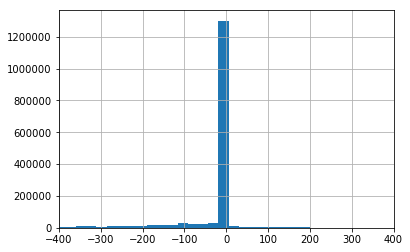

In [97]:
date_diff_hist = projected_vs_actual.hist(bins=5000)
date_diff_hist.set_xlim(-400,400)

In [99]:
sentence_computation['SENTENCE_END'] = sentence_computation["ACTUAL_SENTENCE_END_DATE"]\
                                         .fillna(sentence_computation["PROJECTED_RELEASE_DATE_(PRD)"])


In [100]:
sentence_computation['SENTENCE_END'].max()

Timestamp('2262-01-25 00:00:00')

### "Flatten" Sentence Dates

In [101]:
# For each commitment, getting the lowest beginning date and the highest end date for the full sentence term.
sentence_subset = sentence_computation.groupby(['INMATE_DOC_NUMBER', 'INMATE_COMMITMENT_PREFIX'])\
        .agg({'SENTENCE_BEGIN_DATE_(FOR_MAX)': min, 
              'SENTENCE_END': max,
              'PAROLE_SUPERVISION_BEGIN_DATE': min,
              'PAROLE_DISCHARGE_DATE': max
             }
            ).reset_index()

#### Null end dates encode life sentence_computations, so I will set the sentence_end to 2262-01-01 (near top of pandas date range)

In [104]:
sentence_subset.loc[sentence_subset.SENTENCE_END.isnull()].shape

(2689, 6)

In [105]:
sentence_subset.loc[sentence_subset.SENTENCE_END.isnull(), "SENTENCE_END"] = pd.to_datetime('2262-1-1')


In [110]:
sentence_subset.head()

,INMATE_DOC_NUMBER,INMATE_COMMITMENT_PREFIX,SENTENCE_BEGIN_DATE_(FOR_MAX),SENTENCE_END,PAROLE_SUPERVISION_BEGIN_DATE,PAROLE_DISCHARGE_DATE
0,4,AA,1983-07-12,1984-07-11,NaT,NaT
1,6,AA,1973-01-30,1973-03-28,NaT,NaT
2,6,AB,1973-04-11,1975-08-18,NaT,NaT
3,8,AA,1990-04-09,1990-05-17,NaT,NaT
4,8,AB,1993-08-30,1994-01-26,NaT,NaT


In [108]:
# sentence_subset.to_pickle('data/preprocessed/sentence_subset.pkl')

In [226]:
sentence_subset = pd.read_pickle('data/preprocessed/sentence_subset.pkl')

### Bringing In the Court Commitments Table

Now I will join the sentencing dates derived above to the courts data. The resulting table is called `admissions`.

In [111]:
admissions = sentence_subset.merge(court_commit, left_on = ["INMATE_DOC_NUMBER", "INMATE_COMMITMENT_PREFIX"],
                                     right_on=['OFFENDER_NC_DOC_ID_NUMBER','COMMITMENT_PREFIX'])
admissions.drop(['OFFENDER_NC_DOC_ID_NUMBER', 'COMMITMENT_PREFIX'], axis=1, inplace=True)

In [112]:
admissions.tail(3)

,INMATE_DOC_NUMBER,INMATE_COMMITMENT_PREFIX,SENTENCE_BEGIN_DATE_(FOR_MAX),SENTENCE_END,PAROLE_SUPERVISION_BEGIN_DATE,PAROLE_DISCHARGE_DATE,OFFENDER_ADMISSION/INTAKE_DATE,NEW_PERIOD_OF_INCARCERATION_FL,P&P_COMMITMENT_STATUS_FLAG,NEW_PERIOD_OF_SUPERVISION_FLAG
882792,1577605,BA,2018-04-17,2028-11-18,NaT,NaT,2018-04-28,Y,NORMAL NORM,N
882793,1577614,BA,2018-04-16,2019-10-26,NaT,NaT,2018-04-30,Y,NORMAL NORM,N
882794,1577620,BA,2018-12-17,2019-03-17,NaT,NaT,2019-01-16,Y,NORMAL NORM,N


In [113]:
admissions.shape

(882795, 10)

In [114]:
admissions.loc[admissions['INMATE_DOC_NUMBER'] == 54932]

,INMATE_DOC_NUMBER,INMATE_COMMITMENT_PREFIX,SENTENCE_BEGIN_DATE_(FOR_MAX),SENTENCE_END,PAROLE_SUPERVISION_BEGIN_DATE,PAROLE_DISCHARGE_DATE,OFFENDER_ADMISSION/INTAKE_DATE,NEW_PERIOD_OF_INCARCERATION_FL,P&P_COMMITMENT_STATUS_FLAG,NEW_PERIOD_OF_SUPERVISION_FLAG
63009,54932,AA,1973-05-21,1973-09-26,NaT,NaT,1973-05-22,Y,NaN,NaN


### Bringing In the Inmates Table

Now I will add the information from the inmates table. This contains demographics and date of birth. I will use this to calculate age at release.

In [115]:
admissions = admissions.merge(inmates, on='INMATE_DOC_NUMBER')

In [120]:
# admissions.to_pickle('data/preprocessed/admissions_w_inmates.pkl')

In [ ]:
# admissions = pd.read_pickle('data/preprocessed/admissions_w_inmates.pkl')

In [119]:
admissions['INMATE_BIRTH_DATE'].min()

Timestamp('1899-08-28 00:00:00')

In [121]:
release_age_calc = lambda x, y: relativedelta(x.to_pydatetime(), y.to_pydatetime()).years if (x is not pd.NaT) and (y is not pd.NaT) else pd.np.nan

# test lambda function
release_age_calc(admissions.loc[0,'SENTENCE_END'],admissions.loc[0,'INMATE_BIRTH_DATE'])

22

In [123]:
# make sure no birthdates are missing
admissions.loc[admissions['INMATE_BIRTH_DATE'].isna()].shape

(223, 13)

In [124]:
# make sure no sentence end dates are missing
admissions.loc[admissions['SENTENCE_END'].isna()].shape

(0, 13)

In [125]:
admissions.loc[admissions['SENTENCE_END'] == pd.to_datetime('2262-1-1')].shape

(2669, 13)

In [201]:
# admissions['AGE_AT_RELEASE'] = ((admissions['SENTENCE_END'] - admissions['INMATE_BIRTH_DATE']) 
#                                 / np.timedelta64(1, 'Y')).astype(int)

# admissions.loc[:,'AGE_AT_RELEASE'] = admissions[
#     ['SENTENCE_END','INMATE_BIRTH_DATE']].apply(lambda x: release_age_calc(*x), axis=1)


In [126]:
# admissions.loc[admissions['INMATE_DOC_NUMBER'].isin([1523385, 1523389, 1523408])]

In [441]:
# admissions.loc[(admissions['AGE_AT_RELEASE'] < 18) & (admissions['AGE_AT_RELEASE'] > 0)].shape

In [442]:
# admissions.loc[(admissions['AGE_AT_RELEASE'] < 15) & (admissions['AGE_AT_RELEASE'] > 0)].shape

In [443]:
# admissions.loc[(admissions['AGE_AT_RELEASE'] <= 0)].shape

In [444]:
# admissions.loc[admissions['AGE_AT_RELEASE'].isna()].shape

In [228]:
# admissions.loc[:,'AGE_AT_RELEASE'] = admissions.loc[:,'AGE_AT_RELEASE'].astype('int')

In [ ]:
# admissions.drop('INMATE_BIRTH_DATE', axis=1, inplace=True)

In [127]:
admissions.tail(3)

,INMATE_DOC_NUMBER,INMATE_COMMITMENT_PREFIX,SENTENCE_BEGIN_DATE_(FOR_MAX),SENTENCE_END,PAROLE_SUPERVISION_BEGIN_DATE,PAROLE_DISCHARGE_DATE,OFFENDER_ADMISSION/INTAKE_DATE,NEW_PERIOD_OF_INCARCERATION_FL,P&P_COMMITMENT_STATUS_FLAG,NEW_PERIOD_OF_SUPERVISION_FLAG,INMATE_GENDER_CODE,INMATE_RACE_CODE,INMATE_BIRTH_DATE
874459,1566234,BA,2019-01-14,2019-06-26,NaT,NaT,2019-02-05,Y,NORMAL NORM,N,MALE,BLACK,1996-12-20
874460,1566265,BA,2018-07-23,2018-10-01,2018-10-01,2019-06-28,2018-08-10,Y,NORMAL NORM,N,FEMALE,WHITE,1968-08-03
874461,1566292,BA,2018-01-02,2018-03-28,2018-03-28,2019-03-28,2018-01-12,Y,NORMAL NORM,Y,MALE,BLACK,1996-04-02


In [128]:
admissions.shape

(874462, 13)

In [129]:
# Saving an intermediate table for easy loading
admissions.to_pickle('data/preprocessed/admissions_w_inmates.pkl')

In [8]:
# Load the above pickle
admissions = pd.read_pickle('data/preprocessed/admissions_w_inmates.pkl')

### Bringing In the Sentences Table

Now I will add the information from the sentences table. This contains the information most pertinent: the crime, punishment, etc. This new table will be called `sentence_info`. Recall that the `sentences` table contains all information for every component of each sentences.

In [130]:
sentence_info = sentences.merge(admissions, left_on=['OFFENDER_NC_DOC_ID_NUMBER','COMMITMENT_PREFIX'],
                                            right_on=["INMATE_DOC_NUMBER", "INMATE_COMMITMENT_PREFIX"])

sentence_info.drop(['OFFENDER_NC_DOC_ID_NUMBER', 'COMMITMENT_PREFIX'], axis=1, inplace=True)

In [131]:
sentence_info.columns

Index(['NUMBER_OF_COUNTS', 'LENGTH_OF_SUPERVISION',
       'SENTENCE_EFFECTIVE(BEGIN)_DATE', 'MINIMUM_SENTENCE_LENGTH',
       'MAXIMUM_SENTENCE_LENGTH', 'PRIMARY_OFFENSE_CODE',
       'PRIMARY_FELONY/MISDEMEANOR_CD.', 'PRIOR_RCD._POINTS/CONVICTIONS',
       'COUNTY_OF_CONVICTION_CODE', 'PRIMARY_FELONY/MISDEMEANOR_CD.',
       'SERVING_MIN_OR_MAX_TERM_CODE', 'SENTENCE_TYPE_CODE',
       'PUNISHMENT_TYPE_CODE', 'COURT_TYPE_CODE', 'OFFENSE_QUALIFIER_CODE',
       'SENTENCING_PENALTY_CLASS_CODE', 'PRIOR_RECORD_LEVEL_CODE',
       'INMATE_DOC_NUMBER', 'INMATE_COMMITMENT_PREFIX',
       'SENTENCE_BEGIN_DATE_(FOR_MAX)', 'SENTENCE_END',
       'PAROLE_SUPERVISION_BEGIN_DATE', 'PAROLE_DISCHARGE_DATE',
       'OFFENDER_ADMISSION/INTAKE_DATE', 'NEW_PERIOD_OF_INCARCERATION_FL',
       'P&P_COMMITMENT_STATUS_FLAG', 'NEW_PERIOD_OF_SUPERVISION_FLAG',
       'INMATE_GENDER_CODE', 'INMATE_RACE_CODE', 'INMATE_BIRTH_DATE'],
      dtype='object')

Getting count of rows for each commitment, to normalize some of the variables below. 

In [107]:
# num_distinct_rows = sentence_info.groupby(['INMATE_DOC_NUMBER', 'INMATE_COMMITMENT_PREFIX'])['NUMBER_OF_COUNTS'].count()
num_distinct_rows = sentence_info.groupby(['INMATE_DOC_NUMBER', 'INMATE_COMMITMENT_PREFIX'])['NUMBER_OF_COUNTS'].count()

Getting total number of counts per commitment, percentages by county groups defined above, percentages by offense groups defined above, percentages by misdemeanor/felony, percentages by the flag 'serving min or max sentence', and the means of the minimum sentence lengths, maximum sentence lengths, and length of supervision.

In [142]:
sentence_info['MAXIMUM_SENTENCE_LENGTH'] = pd.to_numeric(sentence_info['MAXIMUM_SENTENCE_LENGTH'], errors='coerce')
sentence_info['LENGTH_OF_SUPERVISION'] = pd.to_numeric(sentence_info['MAXIMUM_SENTENCE_LENGTH'], errors='coerce')
sentence_info['MINIMUM_SENTENCE_LENGTH'] = pd.to_numeric(sentence_info['MAXIMUM_SENTENCE_LENGTH'], errors='coerce')

In [223]:
sentence_counts = sentence_info.groupby(['INMATE_DOC_NUMBER', 'INMATE_COMMITMENT_PREFIX']).agg({
    'NUMBER_OF_COUNTS': 'sum',
    'LENGTH_OF_SUPERVISION':'max',
    'MAXIMUM_SENTENCE_LENGTH':'max',
    'MINIMUM_SENTENCE_LENGTH':'min'
})
sentence_counts.rename({'NUMBER_OF_COUNTS':'SENTENCE_TOTAL_COUNTS'}, inplace=True, axis=1)

In [222]:
offense_counts = sentence_info.groupby(['INMATE_DOC_NUMBER', 'INMATE_COMMITMENT_PREFIX', 'PRIMARY_OFFENSE_CODE']).agg({
    'NUMBER_OF_COUNTS': 'sum',
    'LENGTH_OF_SUPERVISION':'max',
    'MAXIMUM_SENTENCE_LENGTH':'max',
    'MINIMUM_SENTENCE_LENGTH':'min',
    'PRIOR_RCD._POINTS/CONVICTIONS': 'max'
})
offense_counts.rename({'NUMBER_OF_COUNTS':'OFFENSE_TOTAL_COUNTS'}, inplace=True, axis=1)

In [226]:
offense_counts.fillna({'MAXIMUM_SENTENCE_LENGTH': 0, 'MINIMUM_SENTENCE_LENGTH': 0, 
                      'LENGTH_OF_SUPERVISION':0, 'NUMBER_OF_COUNTS': 0,
                      'PRIOR_RCD._POINTS/CONVICTIONS':0}, inplace=True)

In [227]:
sentence_counts.fillna({'MAXIMUM_SENTENCE_LENGTH': 0, 'MINIMUM_SENTENCE_LENGTH': 0, 
                      'LENGTH_OF_SUPERVISION':0, 'NUMBER_OF_COUNTS': 0}, inplace=True)

In [153]:
admissions.columns

Index(['INMATE_DOC_NUMBER', 'INMATE_COMMITMENT_PREFIX',
       'SENTENCE_BEGIN_DATE_(FOR_MAX)', 'SENTENCE_END',
       'PAROLE_SUPERVISION_BEGIN_DATE', 'PAROLE_DISCHARGE_DATE',
       'OFFENDER_ADMISSION/INTAKE_DATE', 'NEW_PERIOD_OF_INCARCERATION_FL',
       'P&P_COMMITMENT_STATUS_FLAG', 'NEW_PERIOD_OF_SUPERVISION_FLAG',
       'INMATE_GENDER_CODE', 'INMATE_RACE_CODE', 'INMATE_BIRTH_DATE'],
      dtype='object')

In [230]:
sentence_and_admissions = admissions.merge(sentence_counts, on=["INMATE_DOC_NUMBER", "INMATE_COMMITMENT_PREFIX"])


In [158]:
# offenses_and_admissions = offense_counts.merge(offense_counts, on=["INMATE_DOC_NUMBER", "INMATE_COMMITMENT_PREFIX"])

In [231]:
sentence_and_admissions.to_pickle('data/preprocessed/sentence_w_admissions.pkl')
# offenses_and_admissions.to_pickle('data/preprocessed/offenses_w_admissions.pkl')

In [229]:
sentence_and_admissions = pd.read_pickle('data/preprocessed/sentence_w_admissions.pkl')
# offenses_and_admissions = pd.read_pickle('data/preprocessed/offenses_w_admissions.pkl')

#### Finalizing Start Dates
If `SENTENCE_BEGIN_DATE_(FOR_MAX)` from the sentence computation table is missing, replace it with `SENTENCE_EFFECTIVE(BEGIN)_DATE` from the sentences table and then `OFFENDER_ADMISSION/INTAKE_DATE` from the court commitment table. If all are null, drop that example.

In [160]:
sentences_table_dates = sentences.groupby(['OFFENDER_NC_DOC_ID_NUMBER', 'COMMITMENT_PREFIX'])\
                          ['SENTENCE_EFFECTIVE(BEGIN)_DATE'].min().to_frame().reset_index()

In [161]:
sentences_table_dates.head()

,OFFENDER_NC_DOC_ID_NUMBER,COMMITMENT_PREFIX,SENTENCE_EFFECTIVE(BEGIN)_DATE
0,1,01,1992-12-14
1,3,01,1988-10-21
2,3,02,2015-02-06
3,4,AA,1983-07-12
4,5,01,1989-08-01


In [232]:
sentence_and_admissions = sentence_and_admissions.merge(sentences_table_dates, left_on=['INMATE_DOC_NUMBER', 'INMATE_COMMITMENT_PREFIX'],
                                                 right_on=['OFFENDER_NC_DOC_ID_NUMBER', 'COMMITMENT_PREFIX'])


In [233]:
sentence_and_admissions.drop(['OFFENDER_NC_DOC_ID_NUMBER', 'COMMITMENT_PREFIX'], axis=1, inplace=True)
sentence_and_admissions.head(10)

,INMATE_DOC_NUMBER,INMATE_COMMITMENT_PREFIX,SENTENCE_BEGIN_DATE_(FOR_MAX),SENTENCE_END,PAROLE_SUPERVISION_BEGIN_DATE,PAROLE_DISCHARGE_DATE,OFFENDER_ADMISSION/INTAKE_DATE,NEW_PERIOD_OF_INCARCERATION_FL,P&P_COMMITMENT_STATUS_FLAG,NEW_PERIOD_OF_SUPERVISION_FLAG,INMATE_GENDER_CODE,INMATE_RACE_CODE,INMATE_BIRTH_DATE,SENTENCE_TOTAL_COUNTS,LENGTH_OF_SUPERVISION,MAXIMUM_SENTENCE_LENGTH,MINIMUM_SENTENCE_LENGTH,SENTENCE_EFFECTIVE(BEGIN)_DATE
0,4,AA,1983-07-12,1984-07-11,NaT,NaT,1983-07-13,Y,NORMAL NORM,NaN,MALE,WHITE,1961-10-15,2,30000.0,30000.0,30000.0,1983-07-12
1,6,AA,1973-01-30,1973-03-28,NaT,NaT,1973-01-30,Y,NaN,NaN,MALE,WHITE,1951-07-17,1,90.0,90.0,90.0,1973-01-30
2,6,AB,1973-04-11,1975-08-18,NaT,NaT,1973-04-15,Y,NORMAL NORM,NaN,MALE,WHITE,1951-07-17,27,0.0,0.0,0.0,1973-04-11
3,8,AA,1990-04-09,1990-05-17,NaT,NaT,1990-04-23,Y,NORMAL NORM,NaN,MALE,WHITE,1963-12-29,1,10000.0,10000.0,10000.0,1990-04-09
4,8,AB,1993-08-30,1994-01-26,NaT,NaT,1993-09-03,Y,NORMAL NORM,NaN,MALE,WHITE,1963-12-29,1,10000.0,10000.0,10000.0,1993-08-30
5,8,BA,1995-01-02,1995-09-14,NaT,NaT,1995-01-13,Y,NORMAL NORM,NaN,MALE,WHITE,1963-12-29,1,20000.0,20000.0,20000.0,1995-01-02
6,10,AA,1975-06-11,1977-03-17,NaT,NaT,1975-06-20,Y,NaN,NaN,MALE,BLACK,1953-05-18,1,0.0,0.0,0.0,1975-06-11
7,10,AB,1975-06-11,1983-06-27,NaT,NaT,1977-03-17,Y,NORMAL NORM,NaN,MALE,BLACK,1953-05-18,3,0.0,0.0,0.0,1975-05-30
8,14,AA,1975-08-18,1976-07-06,NaT,NaT,1975-08-21,Y,NORMAL NORM,NaN,MALE,WHITE,1921-08-26,2,0.0,0.0,0.0,1975-08-18
9,14,AB,1977-06-17,1978-01-23,NaT,NaT,1977-06-21,Y,NORMAL NORM,NaN,MALE,WHITE,1921-08-26,1,0.0,0.0,0.0,1977-06-17


In [164]:
begin_vs_effective = sentence_and_admissions[['SENTENCE_BEGIN_DATE_(FOR_MAX)','SENTENCE_EFFECTIVE(BEGIN)_DATE']].apply(lambda x:date_diff(*x), axis=1)


(-400, 400)

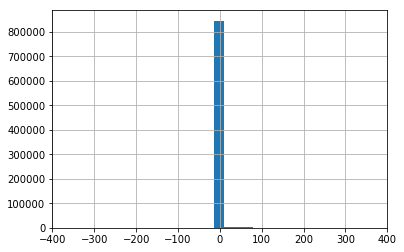

In [171]:
start_diff_hist = begin_vs_effective.hist(bins=2000)
start_diff_hist.set_xlim(-400,400)

In [172]:
begin_vs_intake = sentence_and_admissions[['SENTENCE_BEGIN_DATE_(FOR_MAX)','OFFENDER_ADMISSION/INTAKE_DATE']].apply(lambda x:date_diff(*x), axis=1)


(-400, 400)

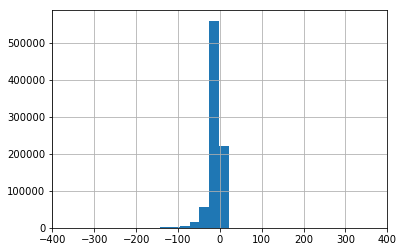

In [175]:
begin_diff_hist = begin_vs_intake.hist(bins=2000)
begin_diff_hist.set_xlim(-400,400)

In [234]:
# Start dates fill NAs all seem to be mostly within 25 days of the begin date, should be find to fill
sentence_and_admissions['SENTENCE_START'] = sentence_and_admissions['SENTENCE_BEGIN_DATE_(FOR_MAX)']\
                                .fillna(sentence_and_admissions['SENTENCE_EFFECTIVE(BEGIN)_DATE'])\
                                .fillna(sentence_and_admissions['OFFENDER_ADMISSION/INTAKE_DATE'])                            

In [179]:
sentence_and_admissions.loc[sentence_and_admissions['SENTENCE_START'].isnull()].shape

(0, 19)

In [181]:
sentence_and_admissions.loc[sentence_and_admissions['SENTENCE_START'].notnull()].shape

(864348, 19)

In [182]:
sentence_and_admissions.shape

(864348, 19)

In [180]:
sentence_and_admissions.head()

,INMATE_DOC_NUMBER,INMATE_COMMITMENT_PREFIX,SENTENCE_BEGIN_DATE_(FOR_MAX),SENTENCE_END,PAROLE_SUPERVISION_BEGIN_DATE,PAROLE_DISCHARGE_DATE,OFFENDER_ADMISSION/INTAKE_DATE,NEW_PERIOD_OF_INCARCERATION_FL,P&P_COMMITMENT_STATUS_FLAG,NEW_PERIOD_OF_SUPERVISION_FLAG,INMATE_GENDER_CODE,INMATE_RACE_CODE,INMATE_BIRTH_DATE,NUMBER_OF_COUNTS,LENGTH_OF_SUPERVISION,MAXIMUM_SENTENCE_LENGTH,MINIMUM_SENTENCE_LENGTH,SENTENCE_EFFECTIVE(BEGIN)_DATE,SENTENCE_START
0,4,AA,1983-07-12,1984-07-11,NaT,NaT,1983-07-13,Y,NORMAL NORM,NaN,MALE,WHITE,1961-10-15,2,30000.0,30000.0,30000.0,1983-07-12,1983-07-12
1,6,AA,1973-01-30,1973-03-28,NaT,NaT,1973-01-30,Y,NaN,NaN,MALE,WHITE,1951-07-17,1,90.0,90.0,90.0,1973-01-30,1973-01-30
2,6,AB,1973-04-11,1975-08-18,NaT,NaT,1973-04-15,Y,NORMAL NORM,NaN,MALE,WHITE,1951-07-17,27,0.0,0.0,0.0,1973-04-11,1973-04-11
3,8,AA,1990-04-09,1990-05-17,NaT,NaT,1990-04-23,Y,NORMAL NORM,NaN,MALE,WHITE,1963-12-29,1,10000.0,10000.0,10000.0,1990-04-09,1990-04-09
4,8,AB,1993-08-30,1994-01-26,NaT,NaT,1993-09-03,Y,NORMAL NORM,NaN,MALE,WHITE,1963-12-29,1,10000.0,10000.0,10000.0,1993-08-30,1993-08-30


In [235]:
sentence_and_admissions.drop(['SENTENCE_BEGIN_DATE_(FOR_MAX)', 'SENTENCE_EFFECTIVE(BEGIN)_DATE', 'OFFENDER_ADMISSION/INTAKE_DATE'], 
                axis=1, inplace=True)

In [236]:
sentence_and_admissions.head()

,INMATE_DOC_NUMBER,INMATE_COMMITMENT_PREFIX,SENTENCE_END,PAROLE_SUPERVISION_BEGIN_DATE,PAROLE_DISCHARGE_DATE,NEW_PERIOD_OF_INCARCERATION_FL,P&P_COMMITMENT_STATUS_FLAG,NEW_PERIOD_OF_SUPERVISION_FLAG,INMATE_GENDER_CODE,INMATE_RACE_CODE,INMATE_BIRTH_DATE,SENTENCE_TOTAL_COUNTS,LENGTH_OF_SUPERVISION,MAXIMUM_SENTENCE_LENGTH,MINIMUM_SENTENCE_LENGTH,SENTENCE_START
0,4,AA,1984-07-11,NaT,NaT,Y,NORMAL NORM,NaN,MALE,WHITE,1961-10-15,2,30000.0,30000.0,30000.0,1983-07-12
1,6,AA,1973-03-28,NaT,NaT,Y,NaN,NaN,MALE,WHITE,1951-07-17,1,90.0,90.0,90.0,1973-01-30
2,6,AB,1975-08-18,NaT,NaT,Y,NORMAL NORM,NaN,MALE,WHITE,1951-07-17,27,0.0,0.0,0.0,1973-04-11
3,8,AA,1990-05-17,NaT,NaT,Y,NORMAL NORM,NaN,MALE,WHITE,1963-12-29,1,10000.0,10000.0,10000.0,1990-04-09
4,8,AB,1994-01-26,NaT,NaT,Y,NORMAL NORM,NaN,MALE,WHITE,1963-12-29,1,10000.0,10000.0,10000.0,1993-08-30


In [240]:
sentence_and_admissions.columns

Index(['INMATE_DOC_NUMBER', 'INMATE_COMMITMENT_PREFIX', 'SENTENCE_END',
       'PAROLE_SUPERVISION_BEGIN_DATE', 'PAROLE_DISCHARGE_DATE',
       'NEW_PERIOD_OF_INCARCERATION_FL', 'P&P_COMMITMENT_STATUS_FLAG',
       'NEW_PERIOD_OF_SUPERVISION_FLAG', 'INMATE_GENDER_CODE',
       'INMATE_RACE_CODE', 'INMATE_BIRTH_DATE', 'SENTENCE_TOTAL_COUNTS',
       'LENGTH_OF_SUPERVISION', 'MAXIMUM_SENTENCE_LENGTH',
       'MINIMUM_SENTENCE_LENGTH', 'SENTENCE_START'],
      dtype='object')

In [241]:
sentence_col_order = ['INMATE_DOC_NUMBER', 'INMATE_COMMITMENT_PREFIX', 'SENTENCE_START', 'SENTENCE_END',
                      'INMATE_RACE_CODE', 'INMATE_BIRTH_DATE', 'INMATE_GENDER_CODE', 'SENTENCE_TOTAL_COUNTS',
                      'NEW_PERIOD_OF_INCARCERATION_FL', 'P&P_COMMITMENT_STATUS_FLAG', 
                      'NEW_PERIOD_OF_SUPERVISION_FLAG', 'MINIMUM_SENTENCE_LENGTH', 'MAXIMUM_SENTENCE_LENGTH',
                      'PAROLE_SUPERVISION_BEGIN_DATE', 'PAROLE_DISCHARGE_DATE', 'LENGTH_OF_SUPERVISION'
        ]

In [242]:
sentences_table = sentence_and_admissions[sentence_col_order]

In [243]:
sentences_table.head()

,INMATE_DOC_NUMBER,INMATE_COMMITMENT_PREFIX,SENTENCE_START,SENTENCE_END,INMATE_RACE_CODE,INMATE_BIRTH_DATE,INMATE_GENDER_CODE,SENTENCE_TOTAL_COUNTS,NEW_PERIOD_OF_INCARCERATION_FL,P&P_COMMITMENT_STATUS_FLAG,NEW_PERIOD_OF_SUPERVISION_FLAG,MINIMUM_SENTENCE_LENGTH,MAXIMUM_SENTENCE_LENGTH,PAROLE_SUPERVISION_BEGIN_DATE,PAROLE_DISCHARGE_DATE,LENGTH_OF_SUPERVISION
0,4,AA,1983-07-12,1984-07-11,WHITE,1961-10-15,MALE,2,Y,NORMAL NORM,NaN,30000.0,30000.0,NaT,NaT,30000.0
1,6,AA,1973-01-30,1973-03-28,WHITE,1951-07-17,MALE,1,Y,NaN,NaN,90.0,90.0,NaT,NaT,90.0
2,6,AB,1973-04-11,1975-08-18,WHITE,1951-07-17,MALE,27,Y,NORMAL NORM,NaN,0.0,0.0,NaT,NaT,0.0
3,8,AA,1990-04-09,1990-05-17,WHITE,1963-12-29,MALE,1,Y,NORMAL NORM,NaN,10000.0,10000.0,NaT,NaT,10000.0
4,8,AB,1993-08-30,1994-01-26,WHITE,1963-12-29,MALE,1,Y,NORMAL NORM,NaN,10000.0,10000.0,NaT,NaT,10000.0


In [244]:
sentences_table.to_pickle('data/preprocessed/sentences_table.pkl')

In [190]:
sentences_table = pd.read_pickle('data/preprocessed/sentences_table.pkl')

In [314]:
sentences_table.tail()

,INMATE_DOC_NUMBER,INMATE_COMMITMENT_PREFIX,SENTENCE_START,SENTENCE_END,INMATE_RACE_CODE,INMATE_BIRTH_DATE,INMATE_GENDER_CODE,SENTENCE_TOTAL_COUNTS,NEW_PERIOD_OF_INCARCERATION_FL,P&P_COMMITMENT_STATUS_FLAG,NEW_PERIOD_OF_SUPERVISION_FLAG,MINIMUM_SENTENCE_LENGTH,MAXIMUM_SENTENCE_LENGTH,PAROLE_SUPERVISION_BEGIN_DATE,PAROLE_DISCHARGE_DATE,LENGTH_OF_SUPERVISION
864343,1566187,BA,2018-01-10,2018-02-22,BLACK,1999-09-05,MALE,1,Y,NORMAL NORM,Y,30600.0,30600.0,NaT,NaT,30600.0
864344,1566198,BA,2018-12-17,2019-10-06,BLACK,1998-09-15,MALE,4,Y,NORMAL NORM,N,10300.0,10300.0,NaT,NaT,10300.0
864345,1566234,BA,2019-01-14,2019-06-26,BLACK,1996-12-20,MALE,3,Y,NORMAL NORM,N,10300.0,10500.0,NaT,NaT,10500.0
864346,1566265,BA,2018-07-23,2018-10-01,WHITE,1968-08-03,FEMALE,1,Y,NORMAL NORM,N,10500.0,10500.0,2018-10-01,2019-06-28,10500.0
864347,1566292,BA,2018-01-02,2018-03-28,BLACK,1996-04-02,MALE,1,Y,NORMAL NORM,Y,20600.0,20600.0,2018-03-28,2019-03-28,20600.0


In [283]:
import ohio.ext.pandas  #noqa

from os import path

def push_tocsv(file_to_write, df):
    """
    :param file_to_write:
    :param df:
    """
    print('pushing to csv...')
    # ipath, input_name = path.split(input_file)
    # outpath = ipath + input_name[:input_file.find('.')] + '_nc_table_' + datestr + '.csv'

    try:
        df.to_csv(file_to_write, encoding='utf-8', index=False)
    except IOError:
        print('push_csv_data: Could not push results to a csv file.')

In [284]:
push_tocsv(file_to_write='sentences_table.csv', df=sentences_table)

pushing to csv...


### Completing Offenses Table

In [445]:
offenses_single_count = sentences.loc[:,:]

In [446]:
offenses_single_count.shape

(4257492, 18)

In [447]:
sentences.shape

(4257492, 18)

In [448]:
reps = [ val for val in sentences.NUMBER_OF_COUNTS ]


In [449]:
offenses_single_count = offenses_single_count.loc[np.repeat(offenses_single_count.index.values, reps)]
offenses_single_count

,OFFENDER_NC_DOC_ID_NUMBER,COMMITMENT_PREFIX,NUMBER_OF_COUNTS,LENGTH_OF_SUPERVISION,SENTENCE_EFFECTIVE(BEGIN)_DATE,MINIMUM_SENTENCE_LENGTH,MAXIMUM_SENTENCE_LENGTH,PRIMARY_OFFENSE_CODE,PRIMARY_FELONY/MISDEMEANOR_CD.,PRIOR_RCD._POINTS/CONVICTIONS,COUNTY_OF_CONVICTION_CODE,SERVING_MIN_OR_MAX_TERM_CODE,SENTENCE_TYPE_CODE,PUNISHMENT_TYPE_CODE,COURT_TYPE_CODE,OFFENSE_QUALIFIER_CODE,SENTENCING_PENALTY_CLASS_CODE,PRIOR_RECORD_LEVEL_CODE
0,1,01,1,NaN,1992-12-14,20000,0,LARCENY (OVER $200),MISD.,0,RANDOLPH,NaN,PROBATION,PRE-SS (FAIR) DCC,DISTRICT,PRINCIPAL,MISD.(PRE-STRUCTURE),NaN
1,3,01,1,NaN,1988-10-21,100000,0,POSSESS WITS SCHEDULE II,FELON,0,FORSYTH,NaN,PROBATION,PRE-SS (FAIR) DCC,SUPERIOR,PRINCIPAL,CLASS H,NaN
2,3,02,1,NaN,2015-02-06,0,0,DWI LEVEL 2,MISD.,0,GUILFORD,MAX.TERM:,PROBATION,DWI,DISTRICT,PRINCIPAL,NON CLASS CODE,NaN
3,4,AA,1,0.0,1983-07-12,0,30000,SELL SCHEDULE II,FELON,0,PERQUIMANS,MAX.TERM:,DEPT OF CORR DIV OF PRISONS,FAIR FELONS,SUPERIOR,AID&ABET,CLASS H,NaN
4,4,AA,1,0.0,1983-07-12,0,30000,SELL SCHEDULE II,FELON,0,PERQUIMANS,MAX.TERM:,DEPT OF CORR DIV OF PRISONS,FAIR FELONS,SUPERIOR,AID&ABET,CLASS H,NaN
5,5,01,1,NaN,1989-08-01,20000,0,LARCENY (OVER $200),MISD.,0,CUMBERLAND,NaN,PROBATION,PRE-SS (FAIR) DCC,DISTRICT,PRINCIPAL,MISD.(PRE-STRUCTURE),NaN
6,5,02,1,NaN,1990-11-05,50000,0,MANUFACTURE SCHEDULE VI,FELON,0,CUMBERLAND,NaN,PROBATION,PRE-SS (FAIR) DCC,SUPERIOR,PRINCIPAL,CLASS I,NaN
7,6,AA,1,0.0,1973-01-30,60,90,WORTHLESS CHECK,MISD.,0,CUMBERLAND,MAX.TERM:,DEPT OF CORR DIV OF PRISONS,PRE-FAIR,DISTRICT,PRINCIPAL,MISD.(PRE-STRUCTURE),NaN
8,6,AB,1,0.0,1973-04-11,30,0,WORTHLESS CHECK,MISD.,0,CUMBERLAND,MIN.TERM:,DEPT OF CORR DIV OF PRISONS,PRE-FAIR,DISTRICT,PRINCIPAL,MISD.(PRE-STRUCTURE),NaN
9,6,AB,1,0.0,1973-04-11,30,0,WORTHLESS CHECK,MISD.,0,CUMBERLAND,MIN.TERM:,DEPT OF CORR DIV OF PRISONS,PRE-FAIR,DISTRICT,PRINCIPAL,MISD.(PRE-STRUCTURE),NaN


In [450]:
offenses_single_count.shape

(4969851, 18)

In [451]:
sentences.shape

(4257492, 18)

#### Investigate discrepancy

I would expect the difference between dataframe rows to be the sum of counts in rows with counts higher than one, less the number of rows with counts higher than one.

In [452]:
sentences.loc[sentences['NUMBER_OF_COUNTS'] > 1, 'NUMBER_OF_COUNTS'].sum()

882614

In [453]:
offenses_single_count.shape[0] - sentences.shape[0]

712359

In [454]:
sentences.loc[sentences['NUMBER_OF_COUNTS'] > 1].shape

(170202, 18)

In [455]:
882614 - 170202

712412

In [456]:
712359 - 712412

-53

In [457]:
# Check whether there are zero-count rows
sentences.loc[sentences['NUMBER_OF_COUNTS'] == 0].shape

(53, 18)

In [458]:
offenses_single_count.loc[offenses_single_count['NUMBER_OF_COUNTS'] > 1, 'NUMBER_OF_COUNTS'] = 1

In [459]:
# spot-check grouped columns against sentences table to make sure rows are correct
offenses_single_count.groupby(['OFFENDER_NC_DOC_ID_NUMBER','COMMITMENT_PREFIX'])['NUMBER_OF_COUNTS'].sum()

OFFENDER_NC_DOC_ID_NUMBER  COMMITMENT_PREFIX
1                          01                    1
3                          01                    1
                           02                    1
4                          AA                    2
5                          01                    1
                           02                    1
6                          AA                    1
                           AB                   27
7                          01                    1
                           02                    1
                           03                    1
                           04                    1
                           05                    1
8                          01                    1
                           02                    1
                           03                    1
                           04                    1
                           05                    1
                           06        

In [460]:
offenses_single_count.rename({'OFFENDER_NC_DOC_ID_NUMBER':'INMATE_DOC_NUMBER','COMMITMENT_PREFIX':'INMATE_COMMITMENT_PREFIX'},inplace=True,axis=1)


In [461]:
offenses_single_count.drop('SENTENCE_EFFECTIVE(BEGIN)_DATE',axis=1, inplace=True)

In [462]:
offenses_single_count.head()

,INMATE_DOC_NUMBER,INMATE_COMMITMENT_PREFIX,NUMBER_OF_COUNTS,LENGTH_OF_SUPERVISION,MINIMUM_SENTENCE_LENGTH,MAXIMUM_SENTENCE_LENGTH,PRIMARY_OFFENSE_CODE,PRIMARY_FELONY/MISDEMEANOR_CD.,PRIOR_RCD._POINTS/CONVICTIONS,COUNTY_OF_CONVICTION_CODE,SERVING_MIN_OR_MAX_TERM_CODE,SENTENCE_TYPE_CODE,PUNISHMENT_TYPE_CODE,COURT_TYPE_CODE,OFFENSE_QUALIFIER_CODE,SENTENCING_PENALTY_CLASS_CODE,PRIOR_RECORD_LEVEL_CODE
0,1,01,1,NaN,20000,0,LARCENY (OVER $200),MISD.,0,RANDOLPH,NaN,PROBATION,PRE-SS (FAIR) DCC,DISTRICT,PRINCIPAL,MISD.(PRE-STRUCTURE),NaN
1,3,01,1,NaN,100000,0,POSSESS WITS SCHEDULE II,FELON,0,FORSYTH,NaN,PROBATION,PRE-SS (FAIR) DCC,SUPERIOR,PRINCIPAL,CLASS H,NaN
2,3,02,1,NaN,0,0,DWI LEVEL 2,MISD.,0,GUILFORD,MAX.TERM:,PROBATION,DWI,DISTRICT,PRINCIPAL,NON CLASS CODE,NaN
3,4,AA,1,0.0,0,30000,SELL SCHEDULE II,FELON,0,PERQUIMANS,MAX.TERM:,DEPT OF CORR DIV OF PRISONS,FAIR FELONS,SUPERIOR,AID&ABET,CLASS H,NaN
4,4,AA,1,0.0,0,30000,SELL SCHEDULE II,FELON,0,PERQUIMANS,MAX.TERM:,DEPT OF CORR DIV OF PRISONS,FAIR FELONS,SUPERIOR,AID&ABET,CLASS H,NaN


In [463]:
offenses_single_count.to_pickle('data/preprocessed/offense_counts_table.pkl')

In [464]:
push_tocsv(file_to_write='offense_counts_table.csv', df=offenses_single_count)

pushing to csv...


In [465]:
offenses_table = pd.read_pickle('data/preprocessed/offense_counts_table.pkl')

In [466]:
offenses_table.head()

,INMATE_DOC_NUMBER,INMATE_COMMITMENT_PREFIX,NUMBER_OF_COUNTS,LENGTH_OF_SUPERVISION,MINIMUM_SENTENCE_LENGTH,MAXIMUM_SENTENCE_LENGTH,PRIMARY_OFFENSE_CODE,PRIMARY_FELONY/MISDEMEANOR_CD.,PRIOR_RCD._POINTS/CONVICTIONS,COUNTY_OF_CONVICTION_CODE,SERVING_MIN_OR_MAX_TERM_CODE,SENTENCE_TYPE_CODE,PUNISHMENT_TYPE_CODE,COURT_TYPE_CODE,OFFENSE_QUALIFIER_CODE,SENTENCING_PENALTY_CLASS_CODE,PRIOR_RECORD_LEVEL_CODE
0,1,01,1,NaN,20000,0,LARCENY (OVER $200),MISD.,0,RANDOLPH,NaN,PROBATION,PRE-SS (FAIR) DCC,DISTRICT,PRINCIPAL,MISD.(PRE-STRUCTURE),NaN
1,3,01,1,NaN,100000,0,POSSESS WITS SCHEDULE II,FELON,0,FORSYTH,NaN,PROBATION,PRE-SS (FAIR) DCC,SUPERIOR,PRINCIPAL,CLASS H,NaN
2,3,02,1,NaN,0,0,DWI LEVEL 2,MISD.,0,GUILFORD,MAX.TERM:,PROBATION,DWI,DISTRICT,PRINCIPAL,NON CLASS CODE,NaN
3,4,AA,1,0.0,0,30000,SELL SCHEDULE II,FELON,0,PERQUIMANS,MAX.TERM:,DEPT OF CORR DIV OF PRISONS,FAIR FELONS,SUPERIOR,AID&ABET,CLASS H,NaN
4,4,AA,1,0.0,0,30000,SELL SCHEDULE II,FELON,0,PERQUIMANS,MAX.TERM:,DEPT OF CORR DIV OF PRISONS,FAIR FELONS,SUPERIOR,AID&ABET,CLASS H,NaN


### Completing Discipline Table


In [191]:
just_dates = sentences_table[['INMATE_DOC_NUMBER', 'INMATE_COMMITMENT_PREFIX', 'SENTENCE_START', 'SENTENCE_END']]

In [192]:
just_dates.head()

,INMATE_DOC_NUMBER,INMATE_COMMITMENT_PREFIX,SENTENCE_START,SENTENCE_END
0,4,AA,1983-07-12,1984-07-11
1,6,AA,1973-01-30,1973-03-28
2,6,AB,1973-04-11,1975-08-18
3,8,AA,1990-04-09,1990-05-17
4,8,AB,1993-08-30,1994-01-26


In [193]:
dates_and_infractions = just_dates.merge(discipline, on='INMATE_DOC_NUMBER')

In [194]:
dates_and_infractions.shape

(10453709, 9)

In [195]:
dates_and_infractions = dates_and_infractions[
    (dates_and_infractions['DISCIPLINARY_INFRACTION_DATE'] >= dates_and_infractions['SENTENCE_START']) &
    (dates_and_infractions['DISCIPLINARY_INFRACTION_DATE'] <= dates_and_infractions['SENTENCE_END'])
]

In [196]:
dates_and_infractions.shape

(3214970, 9)

In [197]:
dates_and_infractions.head()

,INMATE_DOC_NUMBER,INMATE_COMMITMENT_PREFIX,SENTENCE_START,SENTENCE_END,DISCIPLINARY_INFRACTION_DATE,DISCIPLINARY_INFRACTION_CODE,DISCI._SEGREGATION_TIME_(DAYS),INMATE_PLEA_RE._INFRACTION,DISCI.INFRACTION_VERDICT_CODE
0,10,AA,1975-06-11,1977-03-17,1975-07-26,MISUSE SUPPLIES,0.0,GUILTY,GUILTY
1,10,AA,1975-06-11,1977-03-17,1975-07-28,DISOBEY ORDER,0.0,GUILTY,GUILTY
2,10,AA,1975-06-11,1977-03-17,1975-11-23,DISOBEY ORDER,0.0,GUILTY,GUILTY
3,10,AA,1975-06-11,1977-03-17,1976-01-03,DISOBEY ORDER,0.0,GUILTY,GUILTY
4,10,AA,1975-06-11,1977-03-17,1976-01-22,DISOBEY ORDER,0.0,GUILTY,GUILTY


In [198]:
dates_and_infractions.to_pickle('data/preprocessed/discipline_table.pkl')

In [286]:
push_tocsv(file_to_write='discipline_table.csv', df=dates_and_infractions)

pushing to csv...


In [402]:
discipline_table = pd.read_pickle('data/preprocessed/discipline_table.pkl')

In [404]:
discipline_table.head()

,INMATE_DOC_NUMBER,INMATE_COMMITMENT_PREFIX,SENTENCE_START,SENTENCE_END,DISCIPLINARY_INFRACTION_DATE,DISCIPLINARY_INFRACTION_CODE,DISCI._SEGREGATION_TIME_(DAYS),INMATE_PLEA_RE._INFRACTION,DISCI.INFRACTION_VERDICT_CODE,EVENT_TYPE
0,10,AA,1975-06-11,1977-03-17,1975-07-26,MISUSE SUPPLIES,0.0,GUILTY,GUILTY,INFRACTION
1,10,AA,1975-06-11,1977-03-17,1975-07-28,DISOBEY ORDER,0.0,GUILTY,GUILTY,INFRACTION
2,10,AA,1975-06-11,1977-03-17,1975-11-23,DISOBEY ORDER,0.0,GUILTY,GUILTY,INFRACTION
3,10,AA,1975-06-11,1977-03-17,1976-01-03,DISOBEY ORDER,0.0,GUILTY,GUILTY,INFRACTION
4,10,AA,1975-06-11,1977-03-17,1976-01-22,DISOBEY ORDER,0.0,GUILTY,GUILTY,INFRACTION


### Preparing for Postgres Import

In [426]:
type_convsersion = {'float64': 'decimal', 'int64':'int', 'datetime64[ns]': 'date', 'object':'varchar'}

In [427]:
for col in discipline_table.columns: 
    print('_'.join(col.split()), type_convsersion[f"{discipline_table[col].dtype}"], ',')

INMATE_DOC_NUMBER varchar ,
INMATE_COMMITMENT_PREFIX varchar ,
SENTENCE_START date ,
SENTENCE_END date ,
DISCIPLINARY_INFRACTION_DATE date ,
DISCIPLINARY_INFRACTION_CODE varchar ,
DISCI._SEGREGATION_TIME_(DAYS) decimal ,
INMATE_PLEA_RE._INFRACTION varchar ,
DISCI.INFRACTION_VERDICT_CODE varchar ,
EVENT_TYPE varchar ,


In [467]:
for col in sentences_table.columns: 
    print('_'.join(col.split()), type_convsersion[f"{sentences_table[col].dtype}"], ',')

INMATE_DOC_NUMBER varchar ,
INMATE_COMMITMENT_PREFIX varchar ,
SENTENCE_START date ,
SENTENCE_END date ,
INMATE_RACE_CODE varchar ,
INMATE_BIRTH_DATE date ,
INMATE_GENDER_CODE varchar ,
SENTENCE_TOTAL_COUNTS int ,
NEW_PERIOD_OF_INCARCERATION_FL varchar ,
P&P_COMMITMENT_STATUS_FLAG varchar ,
NEW_PERIOD_OF_SUPERVISION_FLAG varchar ,
MINIMUM_SENTENCE_LENGTH decimal ,
MAXIMUM_SENTENCE_LENGTH decimal ,
PAROLE_SUPERVISION_BEGIN_DATE date ,
PAROLE_DISCHARGE_DATE date ,
LENGTH_OF_SUPERVISION decimal ,


In [468]:
for col in offenses_table.columns:
    print('_'.join(col.split()), type_convsersion[f"{offenses_table[col].dtype}"], ',')

INMATE_DOC_NUMBER varchar ,
INMATE_COMMITMENT_PREFIX varchar ,
NUMBER_OF_COUNTS int ,
LENGTH_OF_SUPERVISION decimal ,
MINIMUM_SENTENCE_LENGTH int ,
MAXIMUM_SENTENCE_LENGTH varchar ,
PRIMARY_OFFENSE_CODE varchar ,
PRIMARY_FELONY/MISDEMEANOR_CD. varchar ,
PRIOR_RCD._POINTS/CONVICTIONS int ,
COUNTY_OF_CONVICTION_CODE varchar ,
SERVING_MIN_OR_MAX_TERM_CODE varchar ,
SENTENCE_TYPE_CODE varchar ,
PUNISHMENT_TYPE_CODE varchar ,
COURT_TYPE_CODE varchar ,
OFFENSE_QUALIFIER_CODE varchar ,
SENTENCING_PENALTY_CLASS_CODE varchar ,
PRIOR_RECORD_LEVEL_CODE varchar ,
